#### Idalia SWAN-Drifter comparison
/proj/usgs-share/Projects/Idalia2023/run1/2dspec  
/proj/usgs-share/Projects/Idalia2023/run1/his  
/proj/usgs-share/Projects/Idalia2023/run1/qck  

In [1]:
import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path

import matplotlib.colors
import matplotlib.cm as cm

import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

%run -i wave_stats.py

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
DATA_FILENAME = 'hurricane_idalia_drifter_data_v2.pickle'

MODEL_DIRECTORY = '/proj/usgs-share/Projects/Idalia2023/run1/2dspec/'


#### Load Idalia path

In [2]:
import geopandas as gpd
import cartopy.crs as crs
import cartopy.feature as cf
gd1 = gpd.read_file(DATA_DIRECTORY+'track/AL102023_pts.shp')
lt1 = gd1.LAT
ln1 = gd1.LON
hurpth = np.array(list(zip(ln1,lt1)))

#### Load drifter data
The following adapted from the script used to prepare SWAN model output.
`make_swan_input_idalia.ipynb`

In [3]:
with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    drifters = pickle.load(handle)

drifter_types = ['spotter', 'dwsd', 'microswift']
pfx = ['S', 'D', 'M']
# `drifters` is a python dictionary keyed by drifter type (spotter,
# dwsd, or microswift)
# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter = drifters['spotter']
spotter_ids = list(spotter.keys())

dwsd = drifters['dwsd']
dwsd_ids = list(dwsd.keys())
    
mswift = drifters['microswift']
mswift_ids = list(mswift.keys())

In [4]:
# # Make nicknames for these drifters to conform with the max. 8 char limit in SWAN filesname
# # after adding three characters for a counter (to differentiate the POINTS).
snames=['S025D','S052D','S055D','S061D','S066D','S095D','S101D','S102D','S103D','S164D',
    'D9690','D1280','D3160', 'D3730','D0060','D0070','D0090','D0250','D8160','D9490','D8010',
    'M0029','M0037','M0046','M0048']

icount=0
for dtype in drifter_types:
    drifter_data = drifters[dtype]
    for id in list(drifter_data.keys()):
        print(id, snames[icount])
        icount += 1

SPOT-30025D S025D
SPOT-30052D S052D
SPOT-30055D S055D
SPOT-30061D S061D
SPOT-30066D S066D
SPOT-30095D S095D
SPOT-30101D S101D
SPOT-30102D S102D
SPOT-30103D S103D
SPOT-30164D S164D
300534060649690 D9690
300534060941280 D1280
300534064703160 D3160
300534064703730 D3730
300534064800060 D0060
300534064800070 D0070
300534064800090 D0090
300534064800250 D0250
300534061518160 D8160
300534060949490 D9490
300534061518010 D8010
029 M0029
037 M0037
046 M0046
048 M0048


In [5]:
# Create the SWAN output file names, read SWAN model data, and populate bulk statistics arrays

dt = []
time = []
did = []
lat= []
lon= []
hsmod = []
hsobs = []
tpmod = []
tpobs = []
mdirobs  = []
mdirsobs = []
mdirmod  = []
mdirsmod = []
sprd1 = []
sprd1s = []
sigf = []
sigfs = []


igood=0
icount=0
for dtype in drifter_types :
    drifter_data = drifters[dtype]
    for id in drifter_data.keys():

        # Some rows have times with other data but no wave info (Spotters only)
        only_waves = drifter_data[id]['energy_density'].notnull()

        ipt = 0 # index must stay below 1000 or file names will be too long
        for index, row in drifter_data[id][only_waves].loc['2023-08-29 1200':'2023-08-30 1300'].iterrows():
           
            fn = "{}{:03d}.spc2d".format( snames[icount], ipt)
            pathname = os.path.join(MODEL_DIRECTORY, fn)

            if Path(pathname).is_file():
                # drifter obs
                igood+=1
                did.append( snames[icount] )
                dt.append( index )
                time.append( index.strftime('%Y%m%d.%H%m') )
                lat.append( row['latitude'] )
                lon.append( row['longitude'] )
                hsobs.append( row['significant_height'] )
                tpobs.append( row['peak_period'] )
                mdirobs.append( row['mean_direction'] )
                mdirsobs.append( row['mean_directional_spread'] )
                f = row['frequency']
                S = row['energy_density']
                a1 = row['a1']
                b1 = row['b1']
                a2 = row['a2']
                b2 = row['b2']
                # bulk parameters from f, S, a1, b1, etc.
                sigf.append( calc_sigmaf_1d( S, f ) )
                sprd1.append( calc_spread1_a1b1( a1, b1 ) )
                

                # model output
                df = read_swan( pathname )
                hsmod.append( np.squeeze( df.efth.spec.hs().values ) )
                tpmod.append( np.squeeze( df.efth.spec.tp().values ) )
                mdirmod.append(  np.squeeze( df.efth.spec.dpm().values ) )
                mdirsmod.append( np.squeeze( df.efth.spec.dspr().values ) )
                
                fs = df['freq'].values
                dirs = df['dir'].values
                # # flip the directions, so now directions are where waves come from
                dirs = dirs+180
                dirs[dirs>=360.]=dirs[dirs>=360.]-360.

                directional_bin_width_deg = dirs[2]-dirs[1]
                dirs_r = (np.pi/180.)*dirs
                spec2d = np.squeeze( df.efth.values ) 
                
                # This routine is from Isabel
                # Ss, a1s, a2s, b1s, b2s = to_Fourier( spec2d, fs, dirs_r, directional_bin_width_deg, faxis=0, daxis=1 )
                # Because the conventions for a1, b1 are based on cartesian directions and the SWAN 2dspec is geographic,
                # I think we should switch a1 and b1, and change the sign of a2.
                Ss, b1s, a2s, a1s, b2s = to_Fourier( spec2d, fs, dirs_r, directional_bin_width_deg, faxis=0, daxis=1 )
                a2s = -a2s

                # Almost no energy in high frequencies, so truncate
                igood = np.argwhere(Ss>1.e-8)
                fs = np.squeeze(fs[igood])
                Ss = np.squeeze(Ss[igood])
                a1s = np.squeeze(a1s[igood])
                a2s = np.squeeze(a2s[igood])
                b1s = np.squeeze(b1s[igood])
                b2s = np.squeeze(b2s[igood])
                sigfs.append( calc_sigmaf_1d( Ss, fs ) )
                sprd1s.append( calc_spread1_a1b1( a1s, b1s ) )
               
            ipt += 1           
            
        icount +=1

print(igood)


[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]]


In [6]:
# make list of unique ids
ulist = np.unique(did)
print('List of unique ids')
print(ulist)
# eaxample usage: get indexes of all of the entries that match ulist[5]
id_list = np.squeeze( np.argwhere(np.array(did[:])==ulist[0]) )
print(id_list)
# demo doing something with that list
dt[-1]

List of unique ids
['D0060' 'D0070' 'D0090' 'D0250' 'D8010' 'D8160' 'D9490' 'M0029' 'M0037'
 'M0046' 'M0048' 'S025D' 'S052D' 'S055D' 'S061D' 'S066D' 'S095D' 'S101D'
 'S102D' 'S103D' 'S164D']
[251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268
 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286
 287 288 289 290 291 292 293 294 295 296 297 298 299 300]


Timestamp('2023-08-30 12:35:12+0000', tz='UTC')

In [7]:
# convert list of time strings to datetime
dates = [datetime.strptime(date, '%Y%m%d.%H%M') for date in time]

#### Six-panel plot for all drifters 

/tmp/ipykernel_162159/796210285.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2,3, figsize=(12,6))


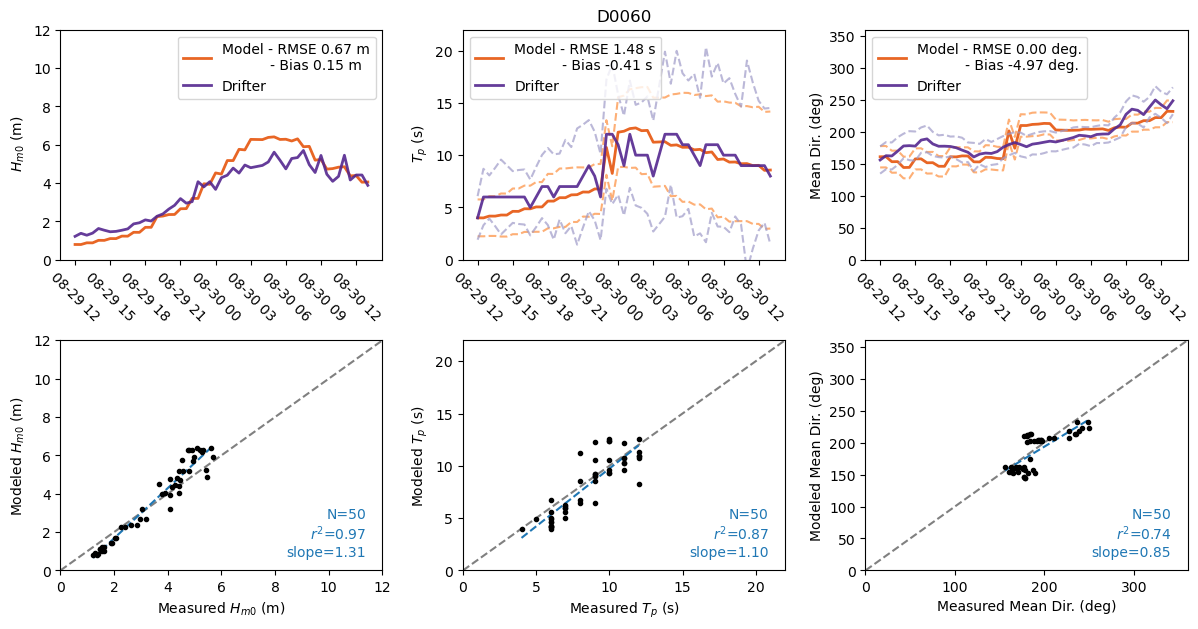

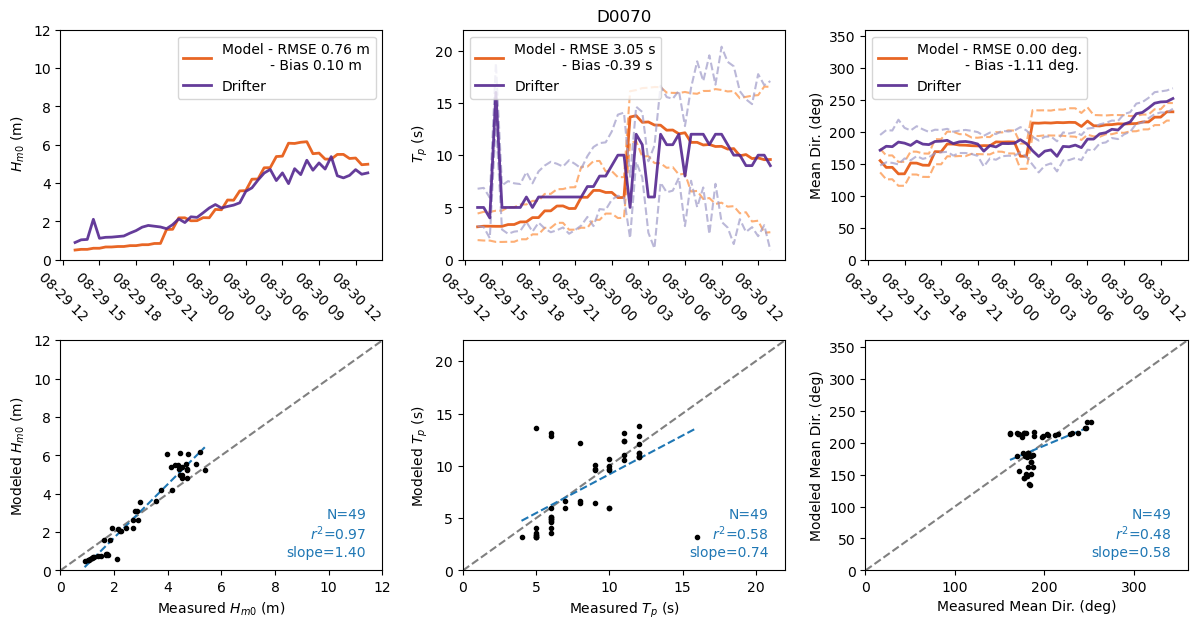

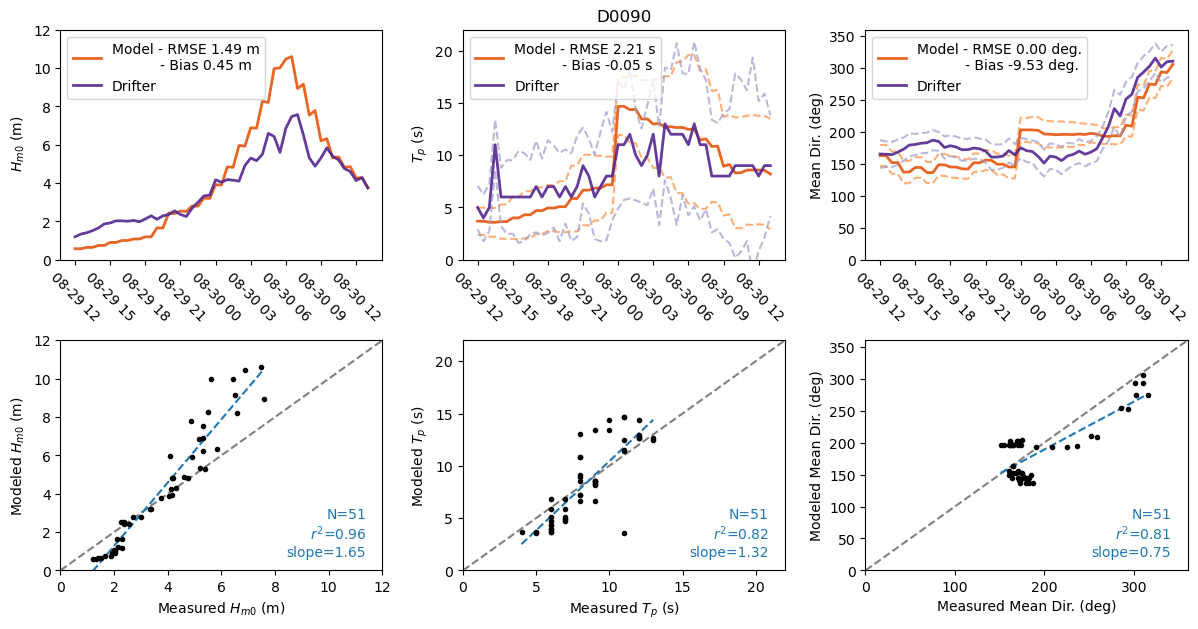

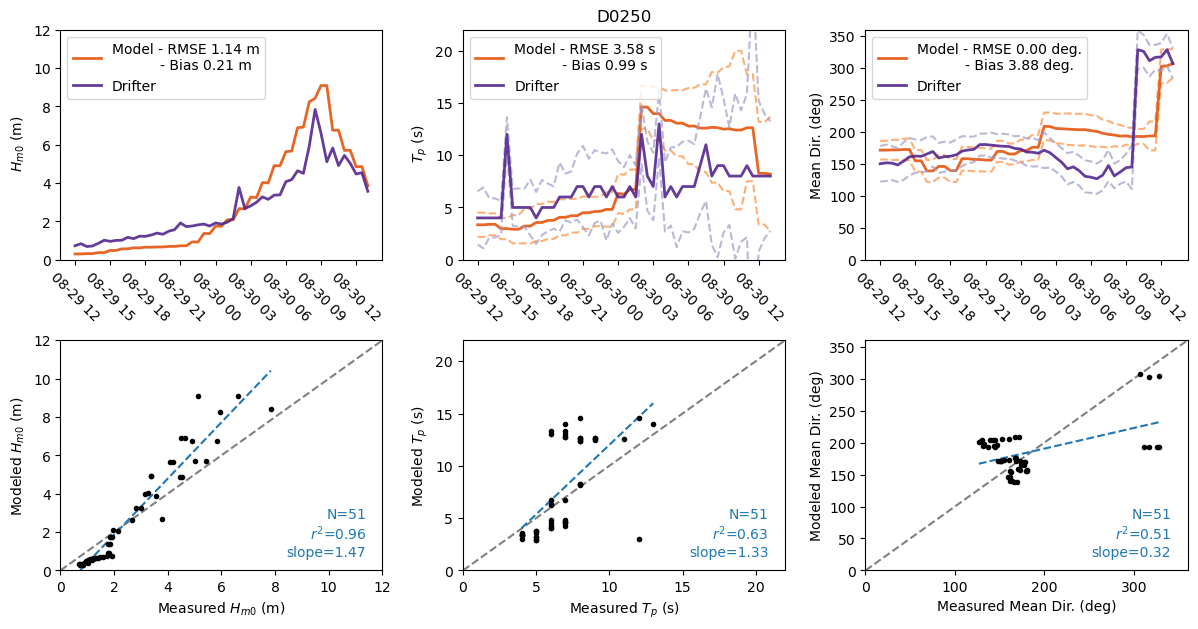

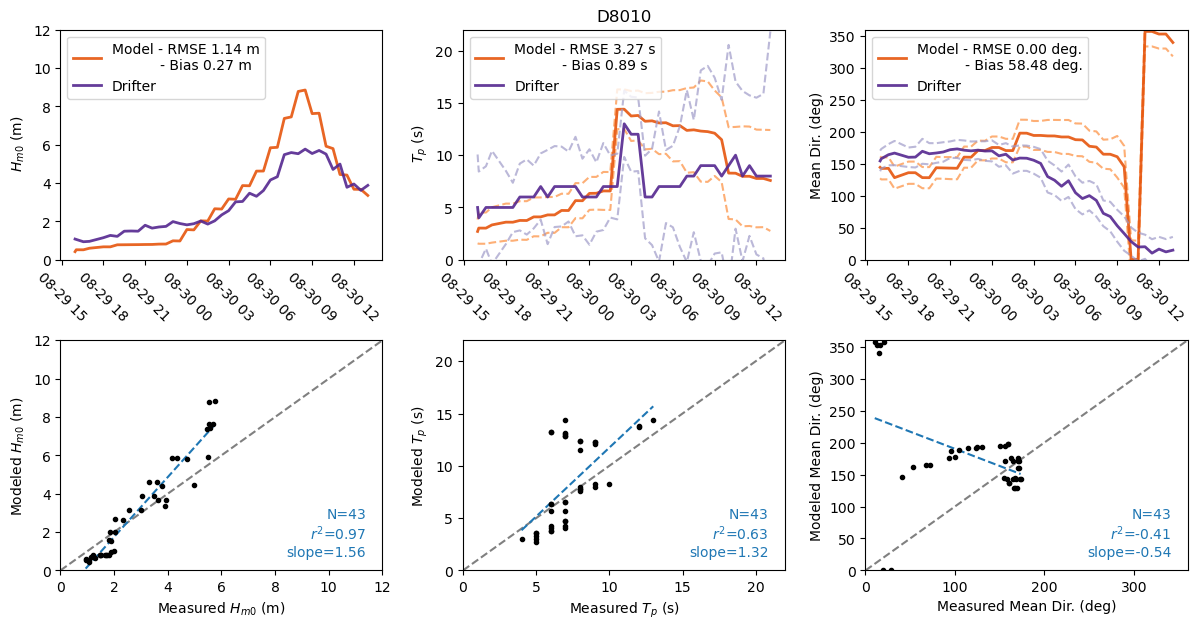

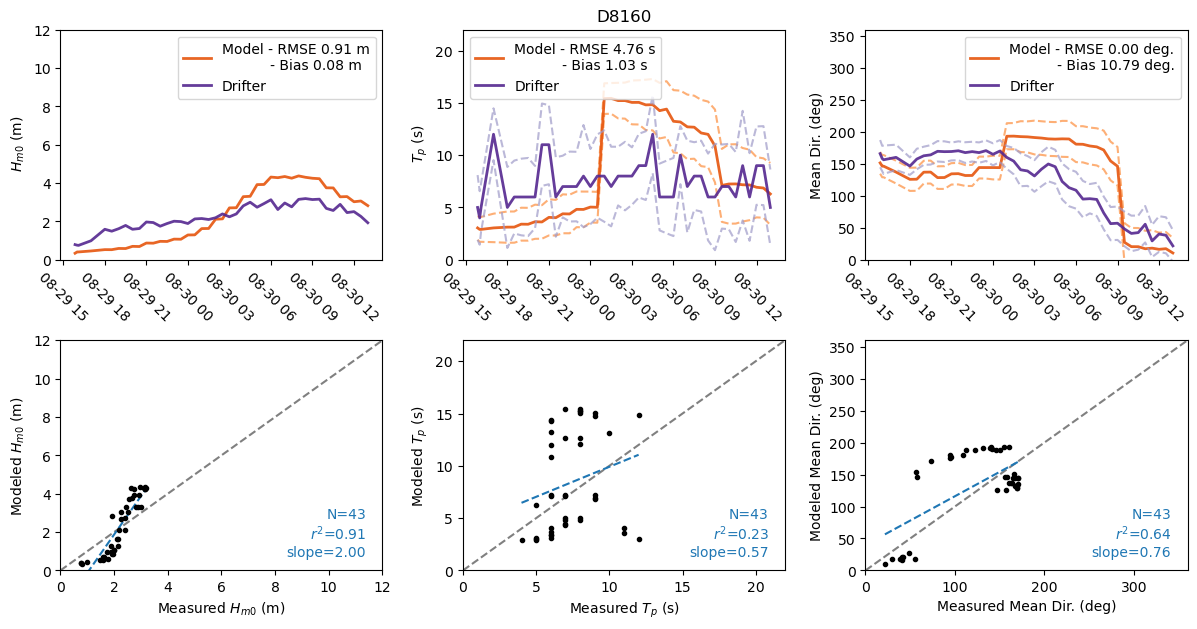

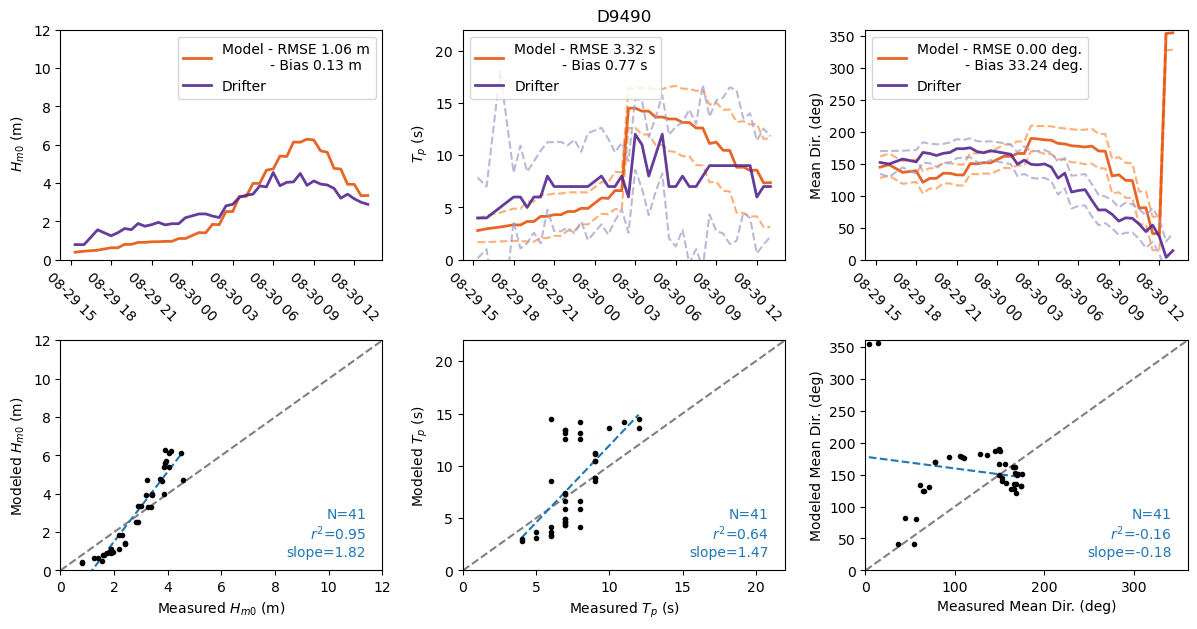

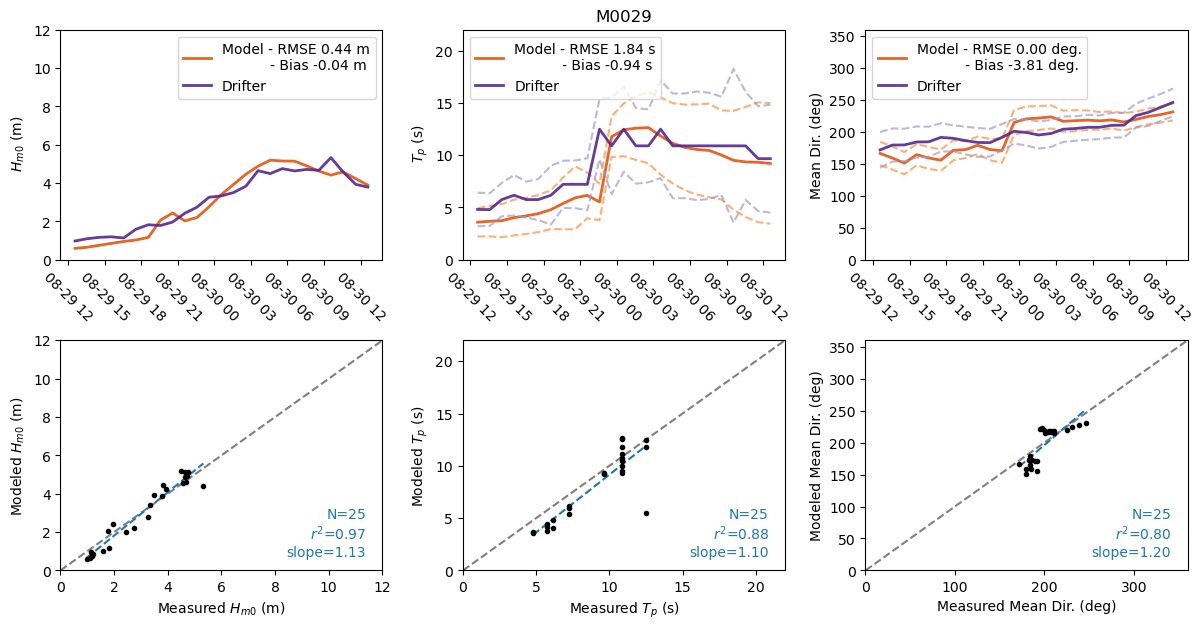

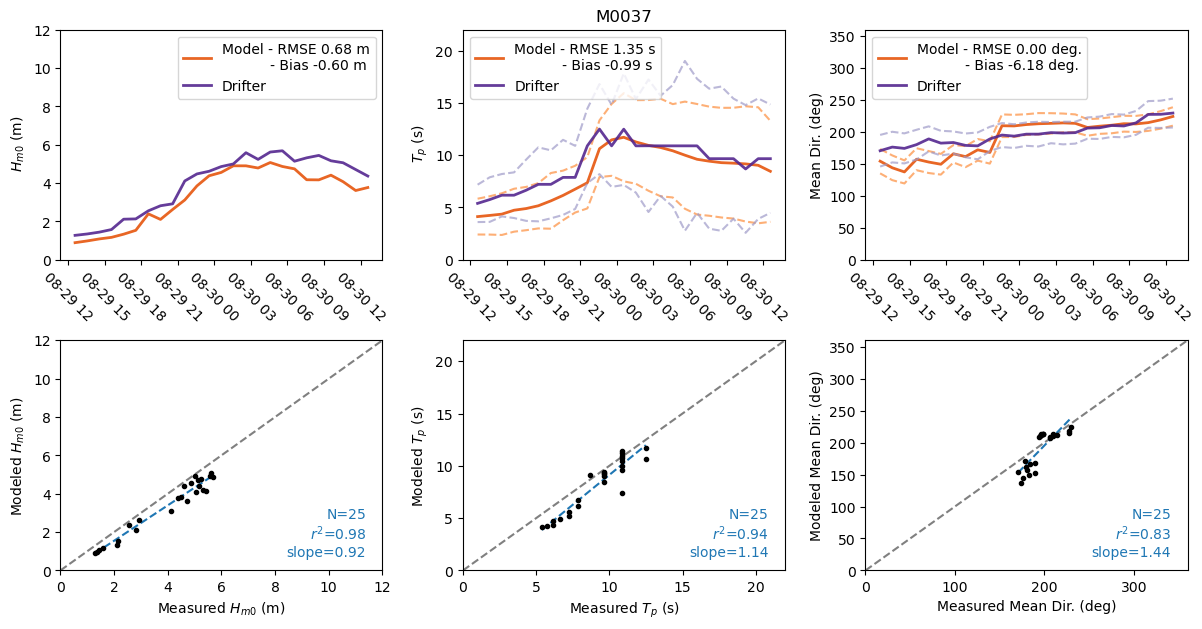

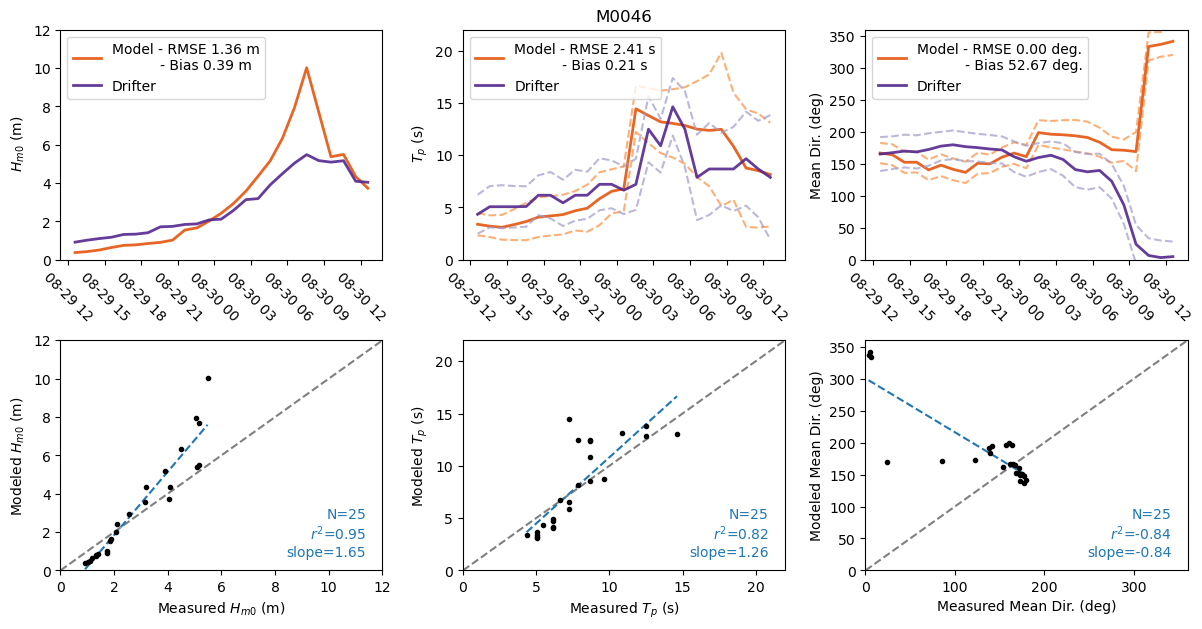

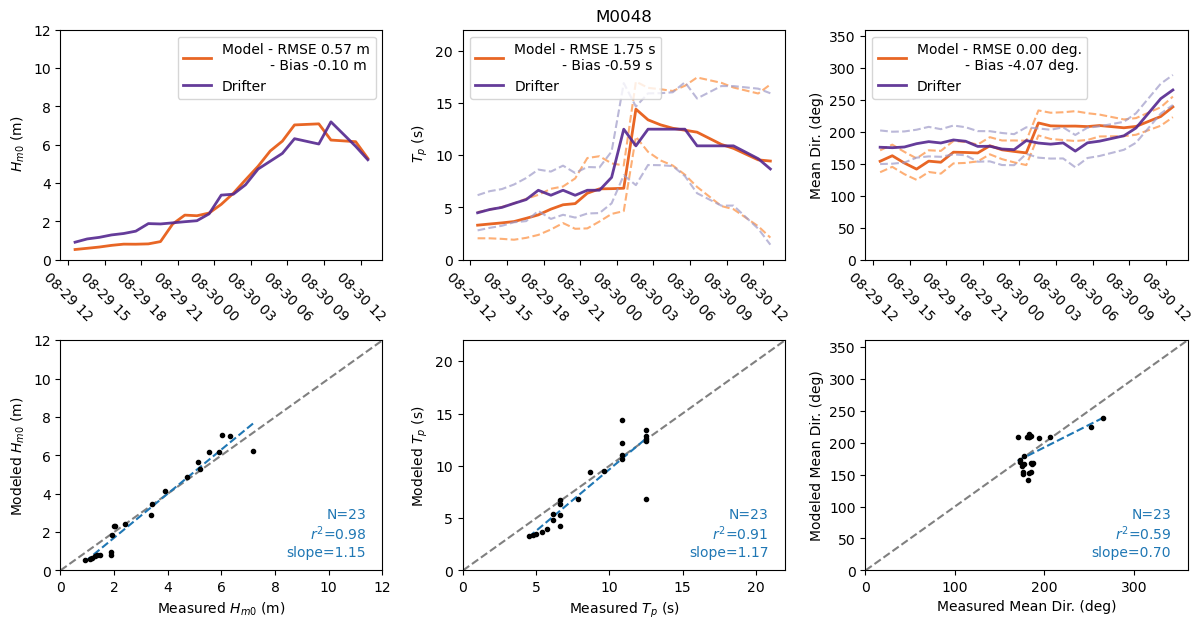

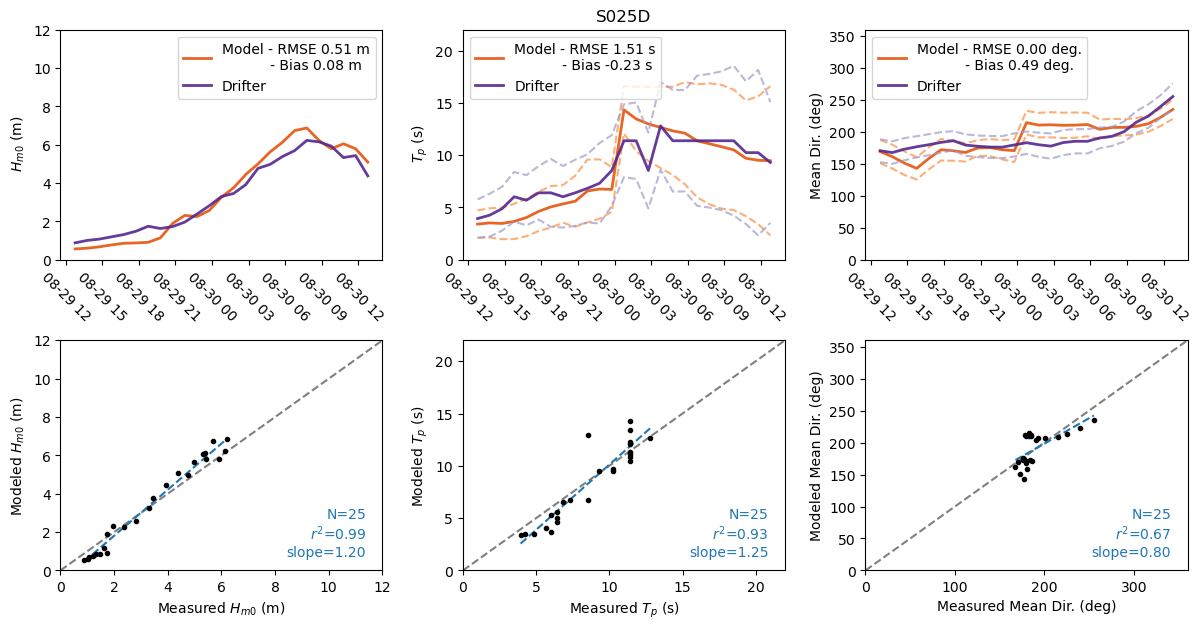

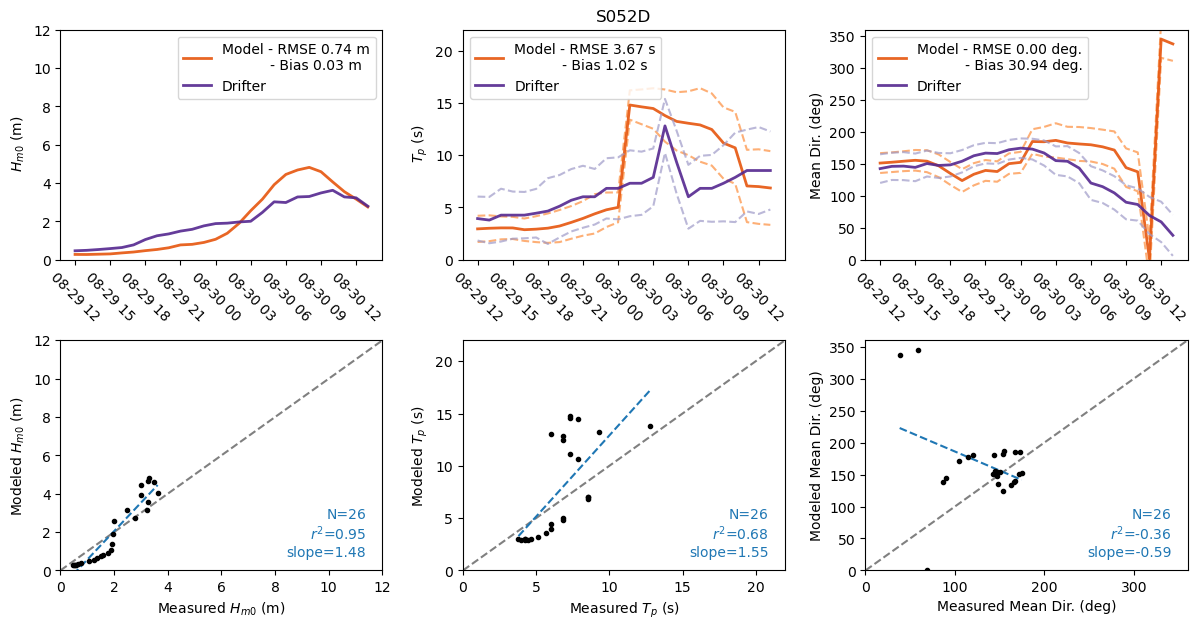

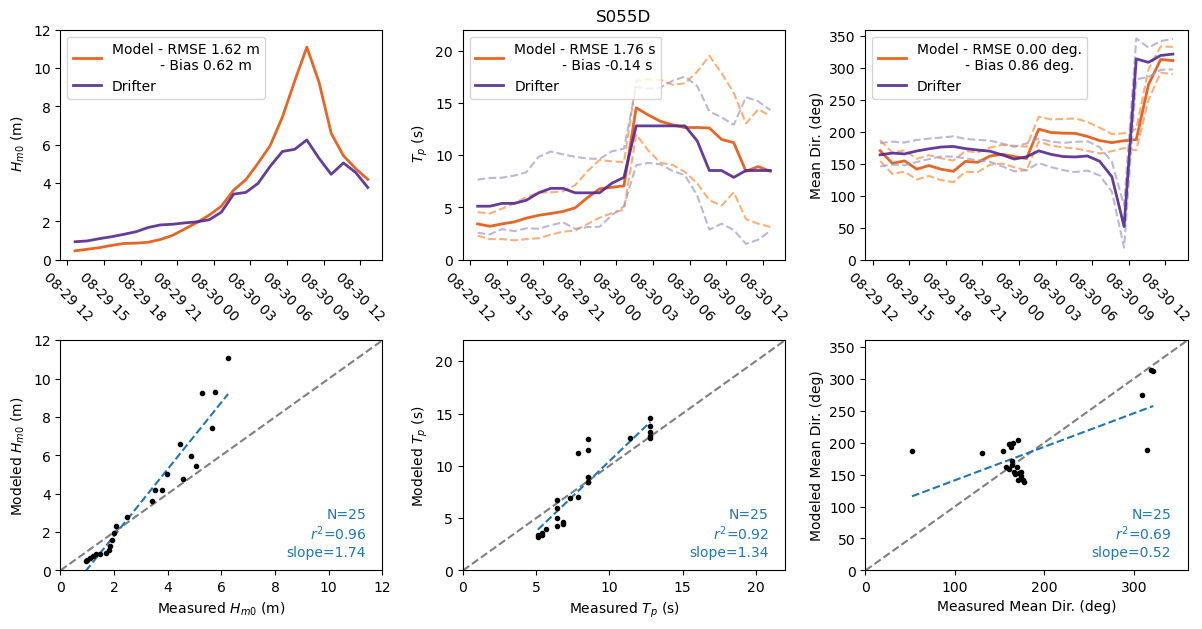

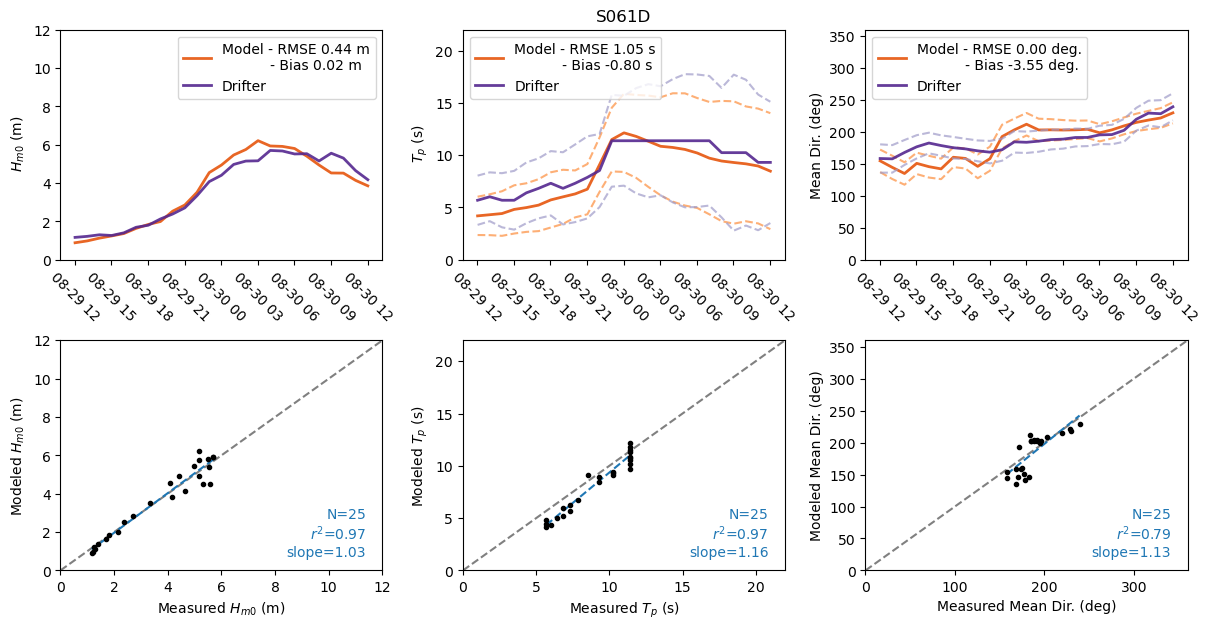

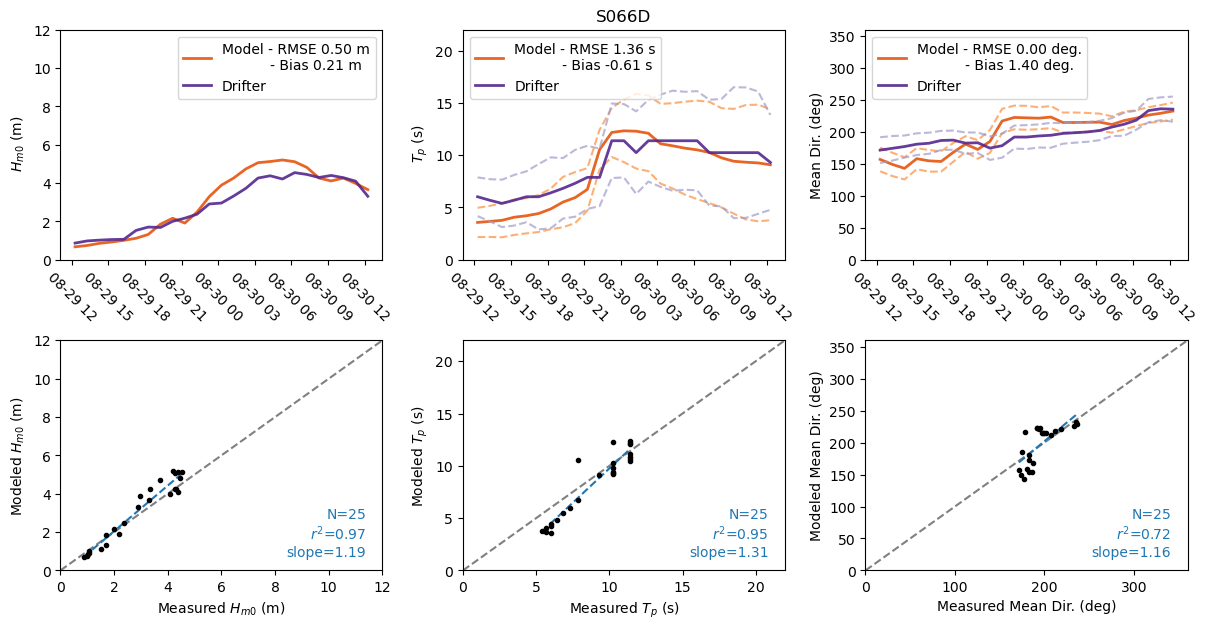

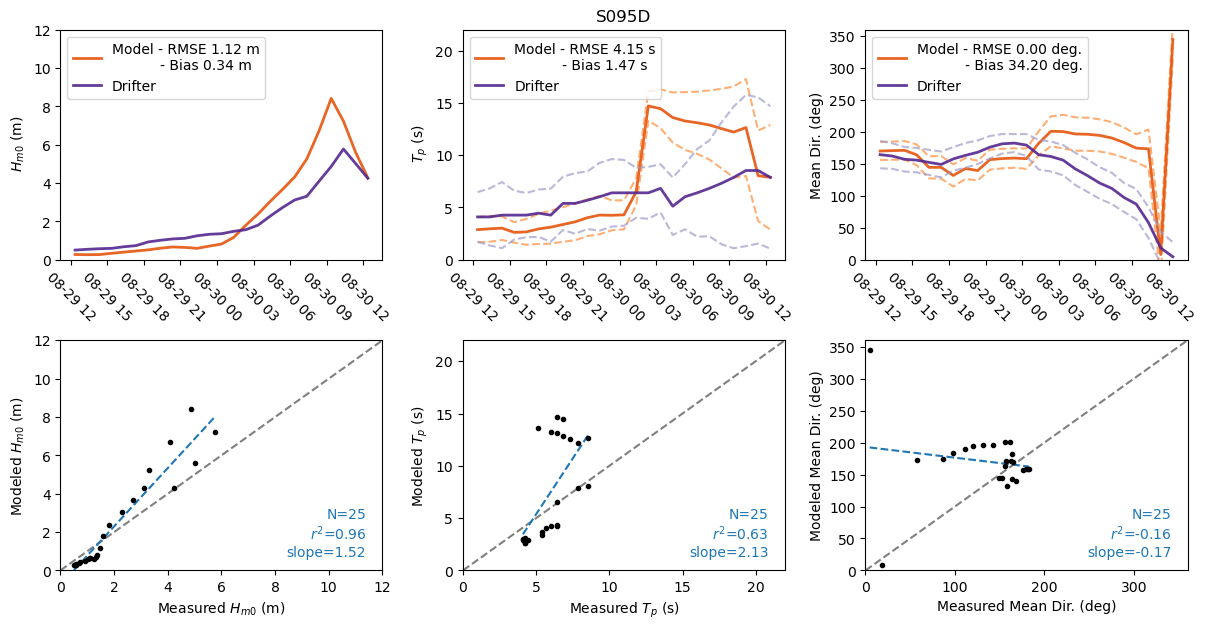

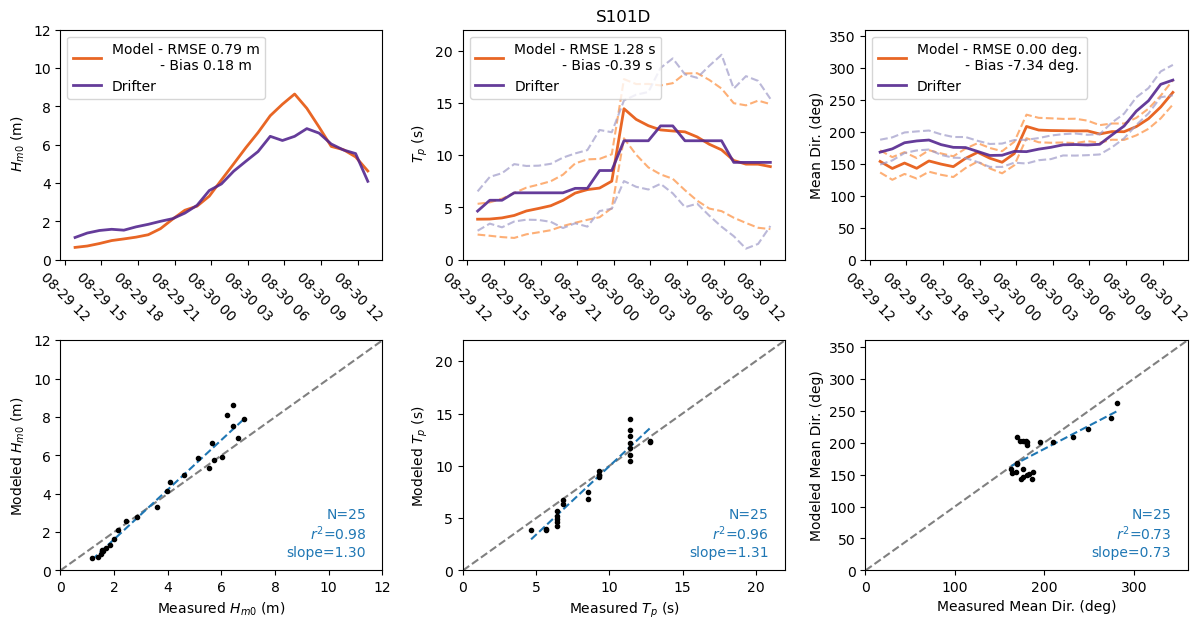

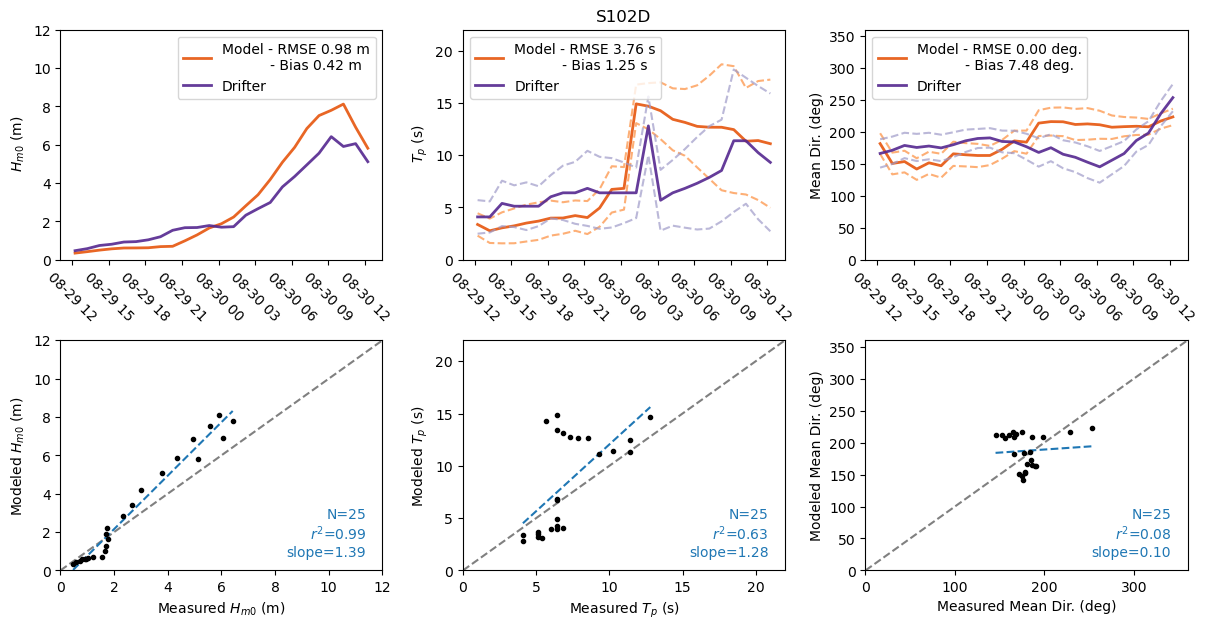

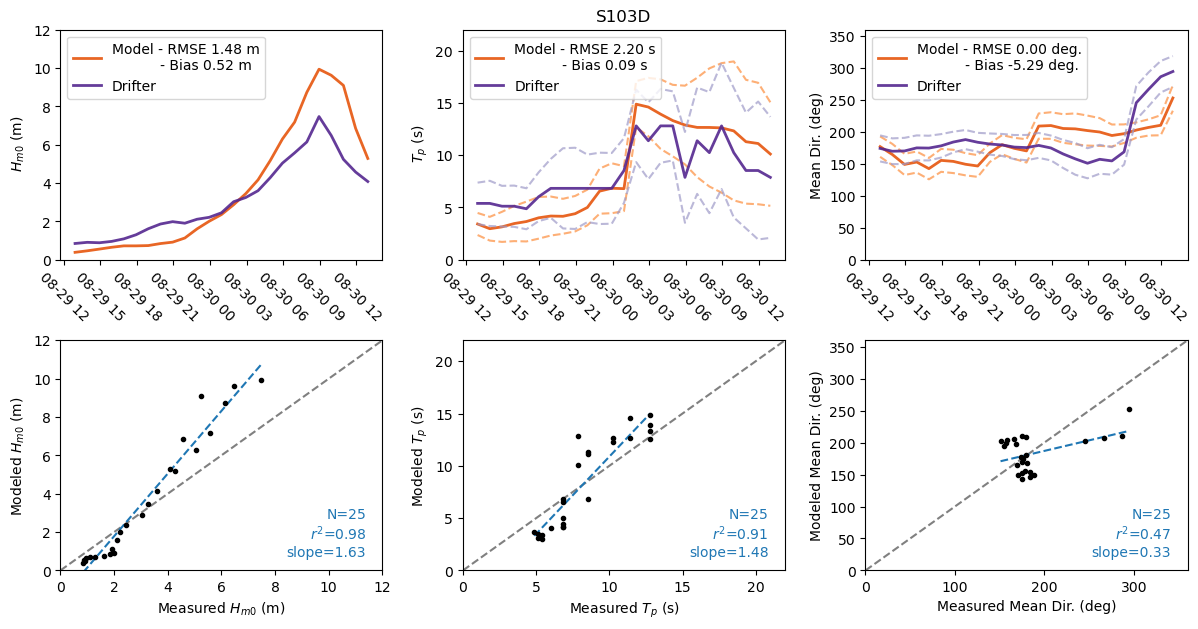

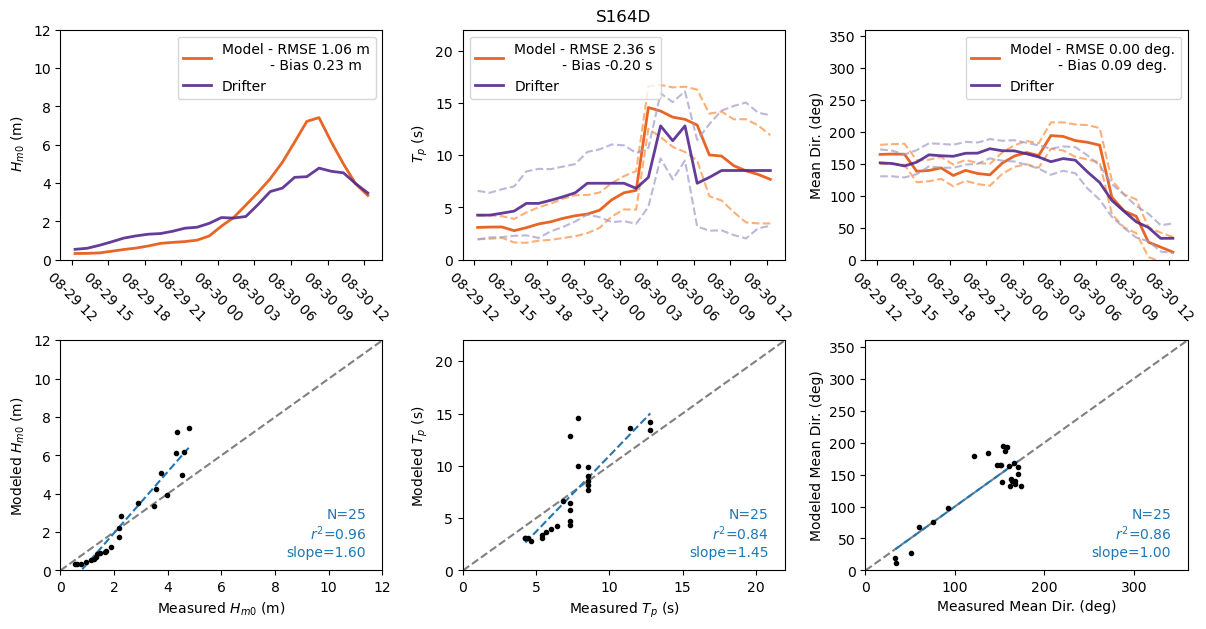

In [8]:
purples = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']
blues = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
oranges = ['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

hm0_bias_list = []
hm0_rmse_list = []
hm0_r2_list = []
hm0_slope_list = []
tp_bias_list = []
tp_rmse_list = []
tp_r2_list = []
tp_slope_list = []
mdir_bias_list = []
mdir_rmse_list = []
mdir_r2_list = []
mdir_slope_list = []
mdirs_bias_list = []
mdirs_rmse_list = []
mdirs_r2_list = []
mdirs_slope_list = []
sigf_bias_list = []
sigf_rmse_list = []
sigf_r2_list = []
sigf_slope_list = []

for item in ulist:

    id_list = np.squeeze( np.argwhere(np.array(did[:])==item) )

    fig, axs = plt.subplots(2,3, figsize=(12,6))
    fig.tight_layout()
    #fig.constrained_layout=True
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.35)

    rmse = np.sqrt( np.mean( (np.array(hsobs)[id_list] - np.array(hsmod)[id_list])**2) )
    bias = np.mean( np.array(hsmod)[id_list] - np.array(hsobs)[id_list] )
    ts = 'Model - RMSE {:.2f} m\n           - Bias {:.2f} m'.format(rmse, bias)
    hm0_bias_list.append( bias )
    hm0_rmse_list.append( rmse )
    axs[0,0].plot(np.array(dt)[id_list], np.array(hsmod)[id_list],'-',linewidth=2,c=oranges[3], alpha=.9, label=ts) 
    axs[0,0].plot(np.array(dt)[id_list], np.array(hsobs)[id_list],'-',linewidth=2,c=purples[4],alpha=.9, label='Drifter')
    axs[0,0].set_ylim((0,12))
    axs[0,0].set_ylabel(r' $H_{m0}$ (m)')
    axs[0,0].legend()
    axs[0,0].tick_params(axis='x', rotation=-45)

    rmse = np.sqrt( np.mean( (np.array(tpobs)[id_list] - np.array(tpmod)[id_list])**2) )
    bias = np.mean( np.array(tpmod)[id_list] - np.array(tpobs)[id_list] )
    ts = 'Model - RMSE {:.2f} s\n           - Bias {:.2f} s'.format(rmse, bias)
    tp_bias_list.append( bias )
    tp_rmse_list.append( rmse )
    axs[0,1].plot(np.array(dt)[id_list], np.array(tpmod)[id_list]+0.5*1./np.array(sigfs)[id_list],'--',c=oranges[2], alpha=.7)
    axs[0,1].plot(np.array(dt)[id_list], np.array(tpmod)[id_list]-0.5*1./np.array(sigfs)[id_list],'--',c=oranges[2], alpha=.7)
    axs[0,1].plot(np.array(dt)[id_list], np.array(tpmod)[id_list],'-',linewidth=2,c=oranges[3], alpha=.9, label=ts) 

    axs[0,1].plot(np.array(dt)[id_list], np.array(tpobs)[id_list]+0.5*1./np.array(sigf)[id_list],'--',c=purples[2], alpha=.7)
    axs[0,1].plot(np.array(dt)[id_list], np.array(tpobs)[id_list]-0.5*1./np.array(sigf)[id_list],'--',c=purples[2], alpha=.7)
    axs[0,1].plot(np.array(dt)[id_list], np.array(tpobs)[id_list],'-',linewidth=2,c=purples[4],alpha=.9, label='Drifter')
    axs[0,1].set_ylim((0,22))
    axs[0,1].set_ylabel(r' $T_{p}$ (s)')
    axs[0,1].legend()
    axs[0,1].tick_params(axis='x', rotation=-45)
    axs[0,1].set_title(item)

    rmse = np.sqrt( np.mean( (np.array(mdirobs)[id_list] - np.array(mdirobs)[id_list])**2) )
    bias = np.mean( np.array(mdirmod)[id_list] - np.array(mdirobs)[id_list] )
    ts = 'Model - RMSE {:.2f} deg.\n           - Bias {:.2f} deg.'.format(rmse, bias)
    mdir_bias_list.append( bias )
    mdir_rmse_list.append( rmse )
    
    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirmod)[id_list]+0.5*np.array(mdirsmod)[id_list],'--',c=oranges[2], alpha=.7)
    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirmod)[id_list]-0.5*np.array(mdirsmod)[id_list],'--',c=oranges[2], alpha=.7)
    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirmod)[id_list],'-',linewidth=2,c=oranges[3],alpha=.9, label=ts)

    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirobs)[id_list]+0.5*np.array(mdirsobs)[id_list],'--',c=purples[2], alpha=.7)
    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirobs)[id_list]-0.5*np.array(mdirsobs)[id_list],'--',c=purples[2], alpha=.7)
    axs[0,2].plot(np.array(dt)[id_list], np.array(mdirobs)[id_list],'-',linewidth=2,c=purples[4],alpha=.9, label='Drifter')
    axs[0,2].set_ylim((0,360))
    axs[0,2].set_ylabel(r'Mean Dir. (deg)')
    axs[0,2].legend()
    axs[0,2].tick_params(axis='x', rotation=-45)
    #

    gradient, intercept, r_value, p_value, std_err = stats.linregress(np.array(hsobs)[id_list],np.array(hsmod)[id_list])
    mn=np.min(np.array(hsobs)[id_list])
    mx=np.max(np.array(hsobs)[id_list])
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(np.array(hsobs)[id_list]),r_value,gradient)
    axs[1,0].plot([0,12],[0,12],'--',c='gray')
    axs[1,0].plot(x1d,y1d,'--',c='tab:blue')
    axs[1,0].plot(np.array(hsobs)[id_list],np.array(hsmod)[id_list],'.k')
    axs[1,0].text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=axs[1,0].transAxes,\
                 horizontalalignment='right', verticalalignment='bottom')
    axs[1,0].set_ylabel('Modeled $H_{m0}$ (m)')
    axs[1,0].set_xlabel('Measured $H_{m0}$ (m)')
    axs[1,0].axis([0, 12, 0, 12])

    gradient, intercept, r_value, p_value, std_err = stats.linregress(np.array(tpobs)[id_list],np.array(tpmod)[id_list])
    mn=np.min(np.array(tpobs)[id_list])
    mx=np.max(np.array(tpobs)[id_list])
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(np.array(tpobs)[id_list]),r_value,gradient)
    axs[1,1].plot([0,22],[0,22],'--',c='gray')
    axs[1,1].plot(x1d,y1d,'--',c='tab:blue')
    axs[1,1].plot(np.array(tpobs)[id_list],np.array(tpmod)[id_list],'.k')
    axs[1,1].text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=axs[1,1].transAxes,\
                 horizontalalignment='right', verticalalignment='bottom')
    axs[1,1].set_ylabel('Modeled $T_{p}$ (s)')
    axs[1,1].set_xlabel('Measured $T_{p}$ (s)')
    axs[1,1].axis([0, 22, 0, 22])

    gradient, intercept, r_value, p_value, std_err = stats.linregress(np.array(mdirobs)[id_list],np.array(mdirmod)[id_list])
    mn=np.min(np.array(mdirobs)[id_list])
    mx=np.max(np.array(mdirobs)[id_list])
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(np.array(mdirobs)[id_list]),r_value,gradient)
    axs[1,2].plot([0,360],[0,360],'--',c='gray')
    axs[1,2].plot(x1d,y1d,'--',c='tab:blue')
    axs[1,2].plot(np.array(mdirobs)[id_list],np.array(mdirmod)[id_list],'.k')
    axs[1,2].text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=axs[1,2].transAxes,\
                 horizontalalignment='right', verticalalignment='bottom')
    axs[1,2].set_ylabel('Modeled Mean Dir. (deg)')
    axs[1,2].set_xlabel('Measured Mean Dir. (deg)')
    axs[1,2].axis([0, 360, 0, 360])
    dirname = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
    #dirname = './'
    figname = 'six_panel_'+item+'.png'
    plt.savefig(dirname+figname, dpi=200, bbox_inches='tight' )

### Spreading plots

/tmp/ipykernel_162159/3315309337.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2,2, figsize=(7,6))


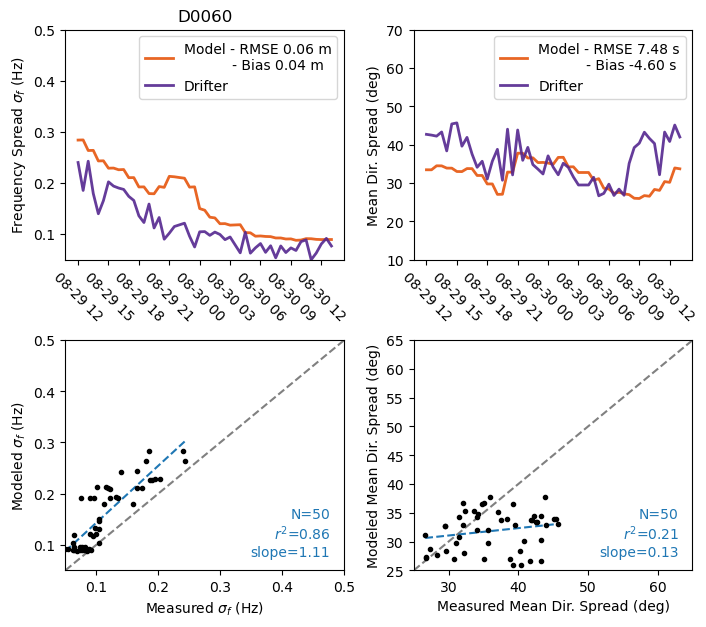

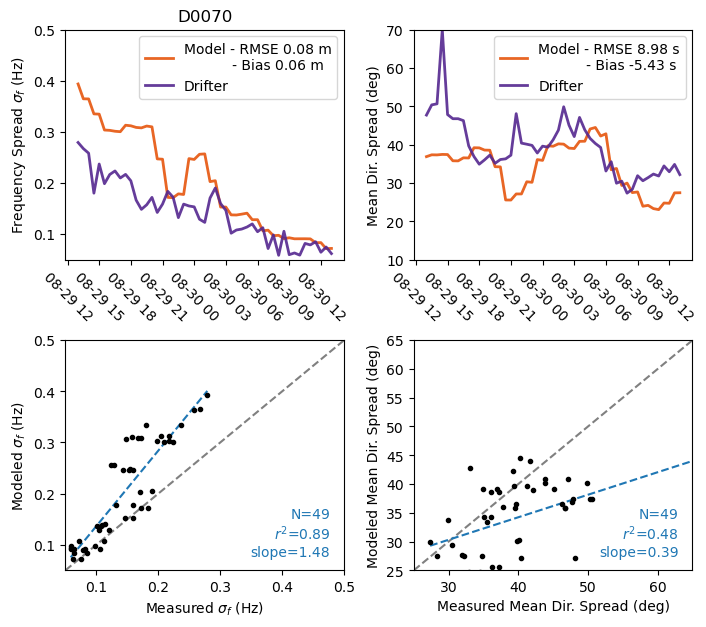

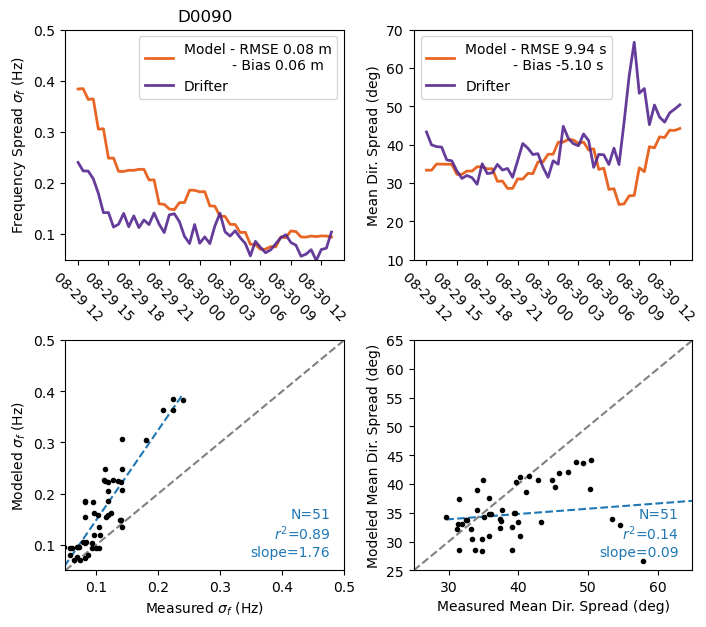

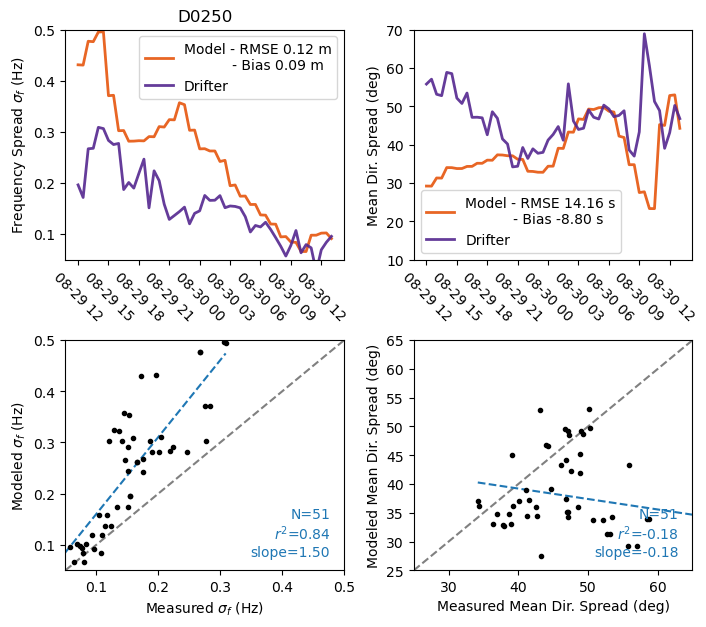

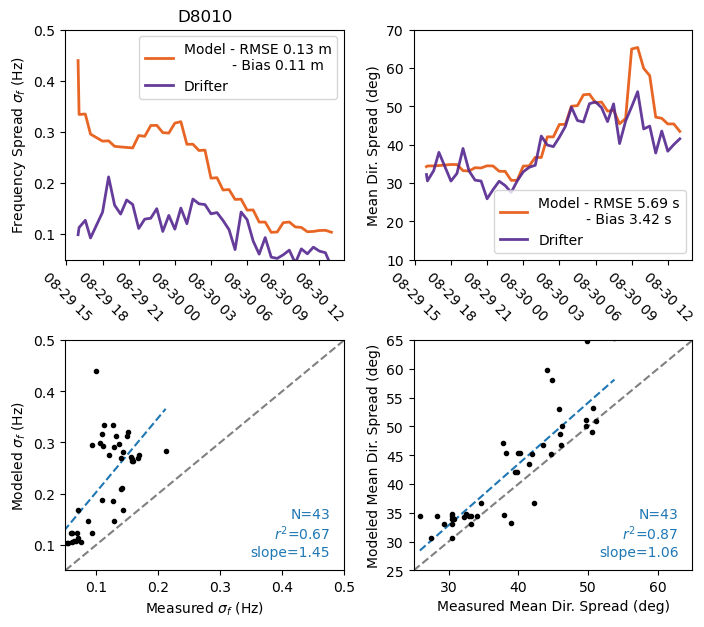

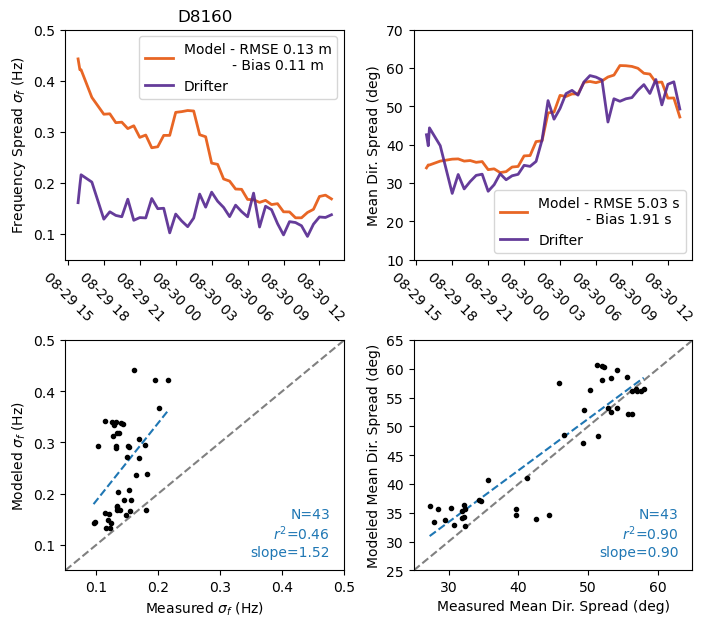

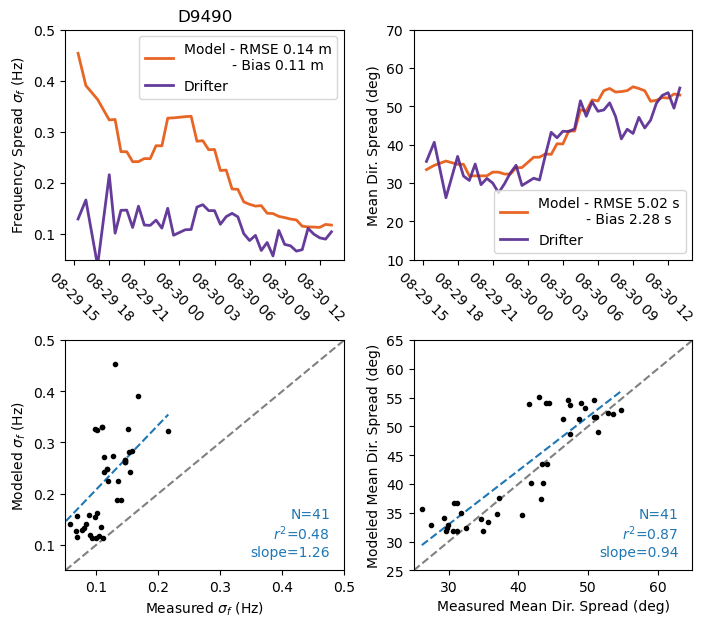

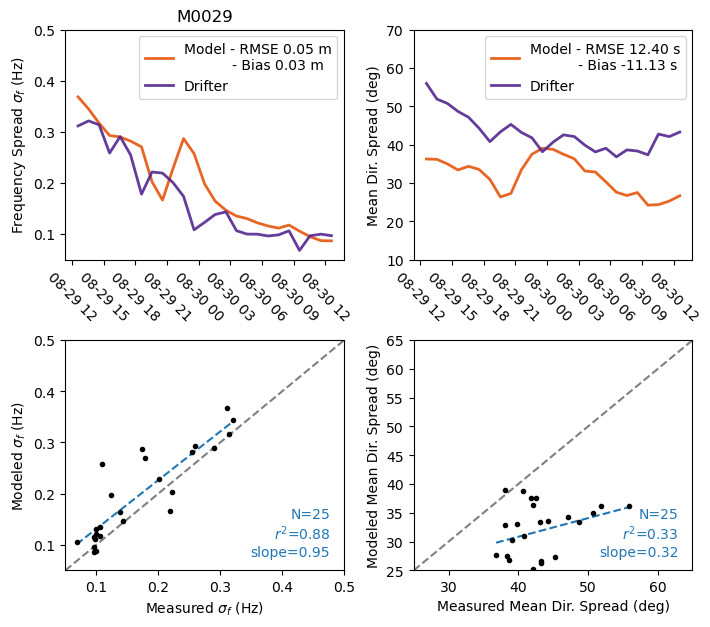

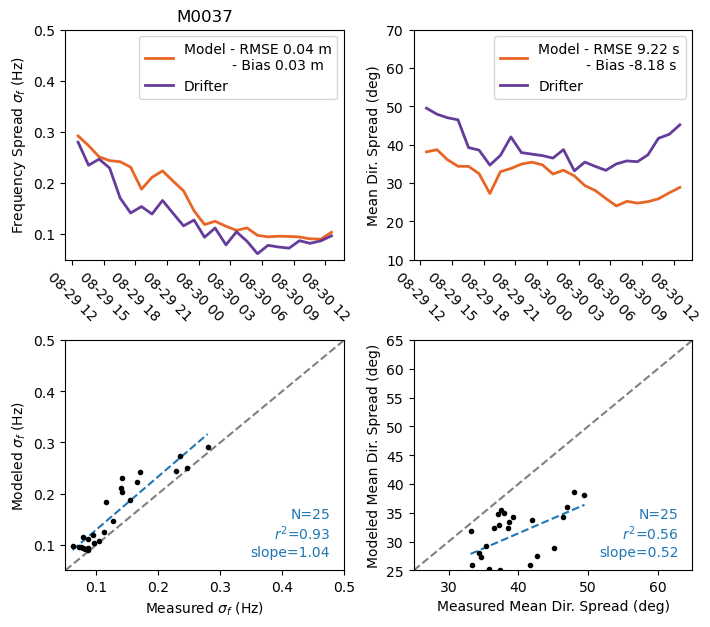

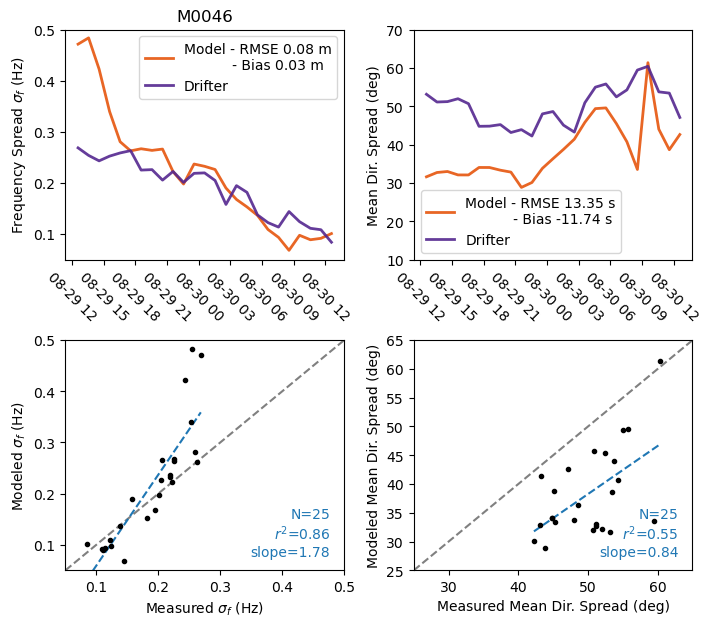

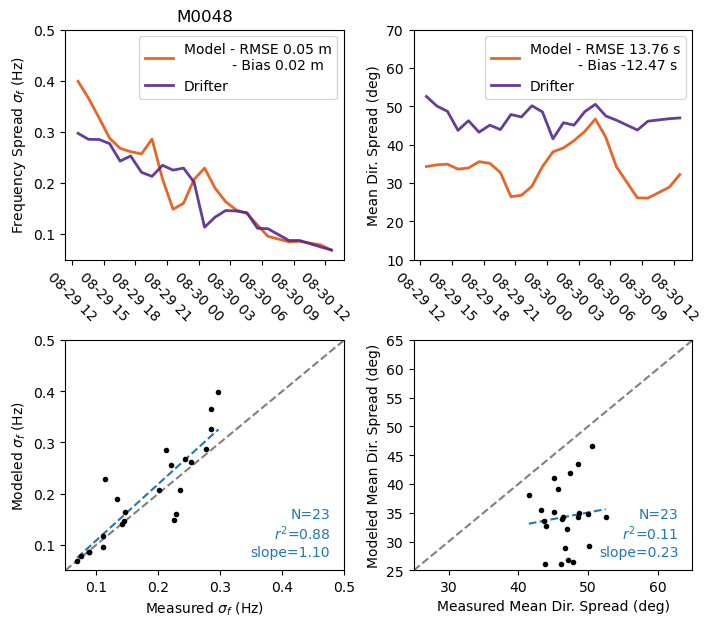

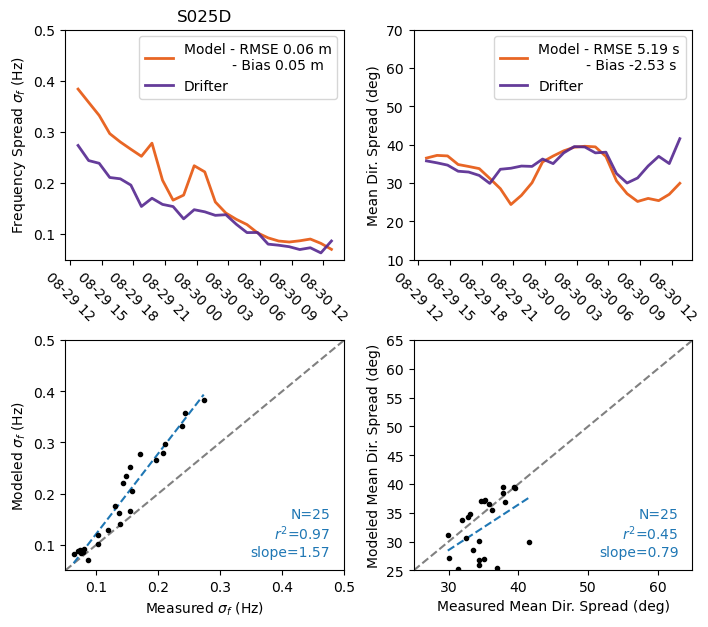

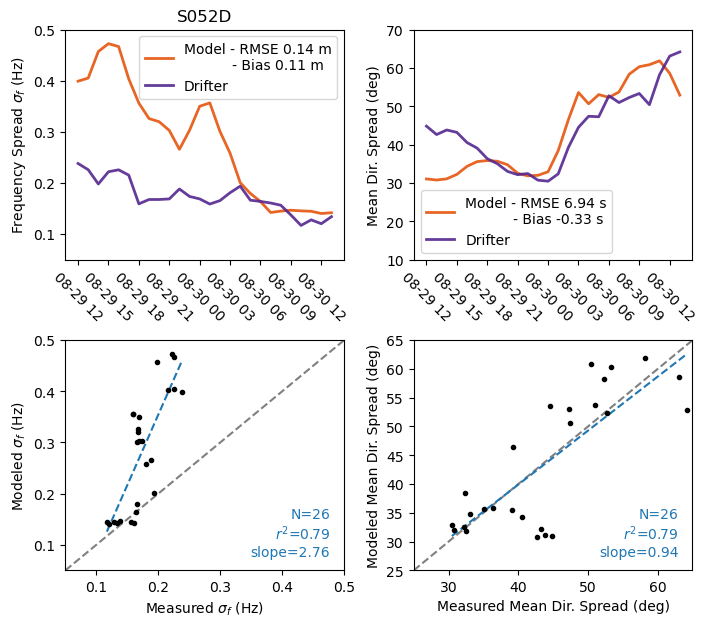

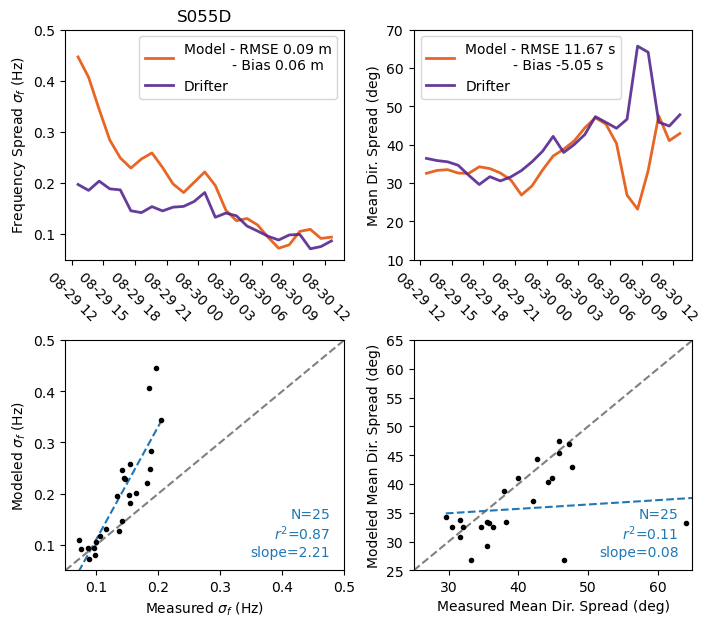

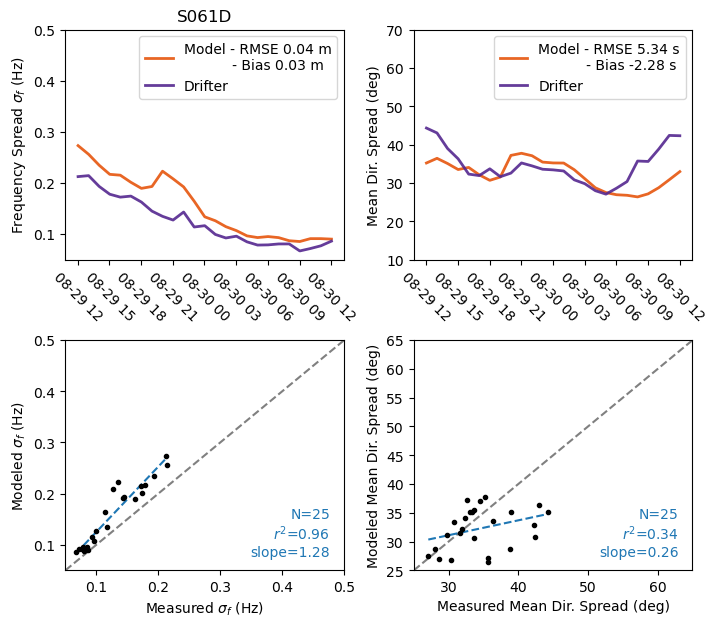

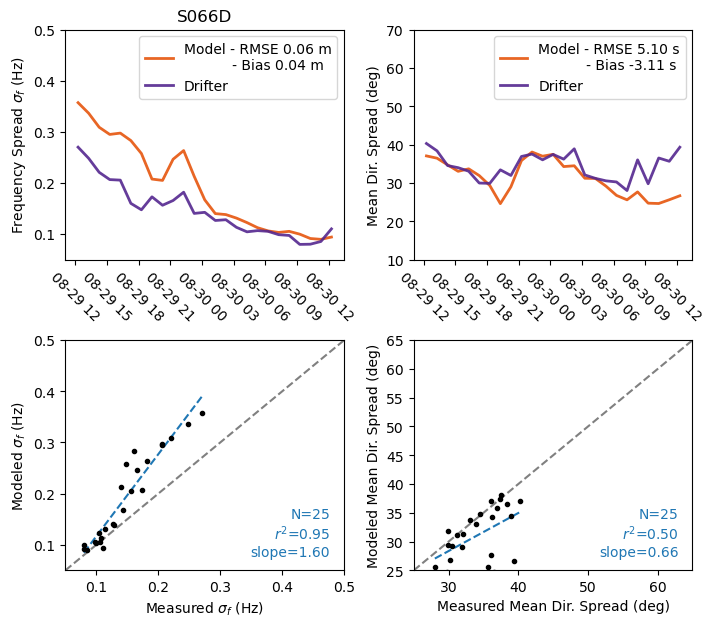

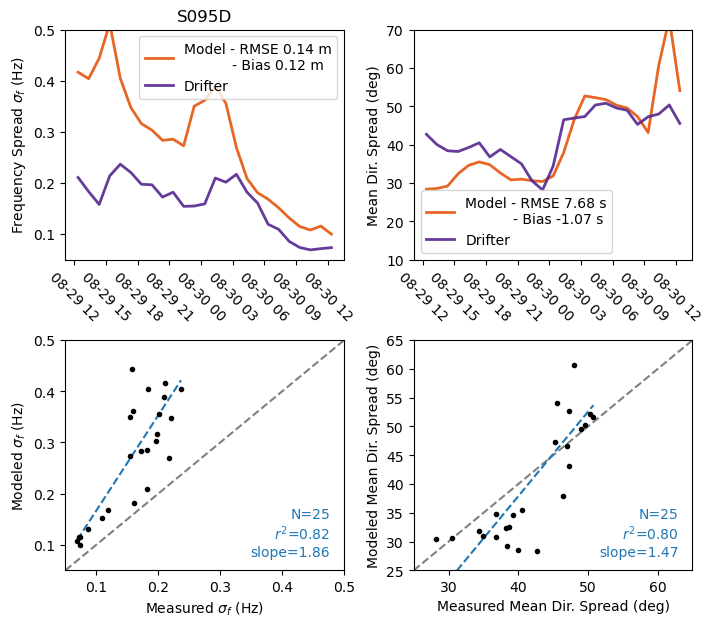

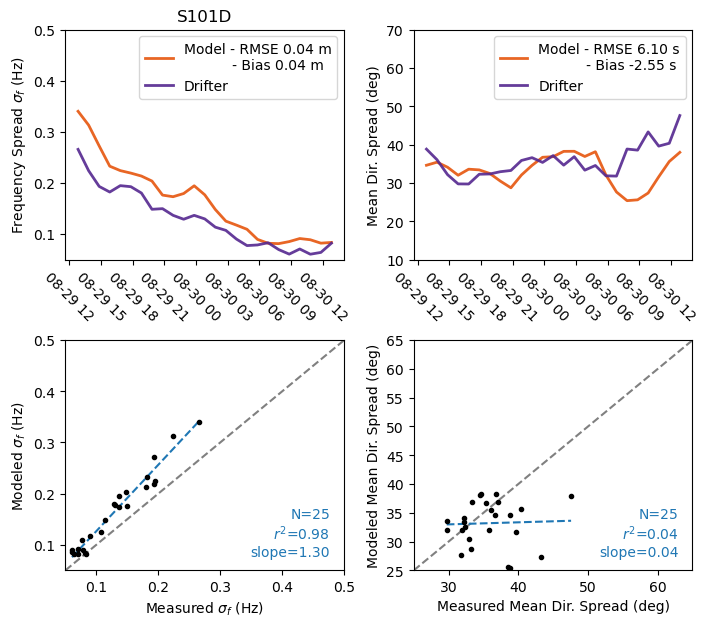

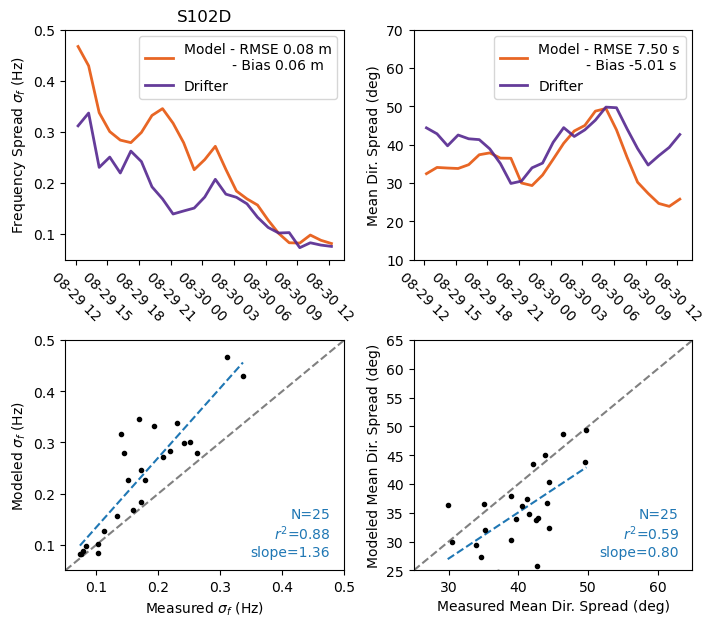

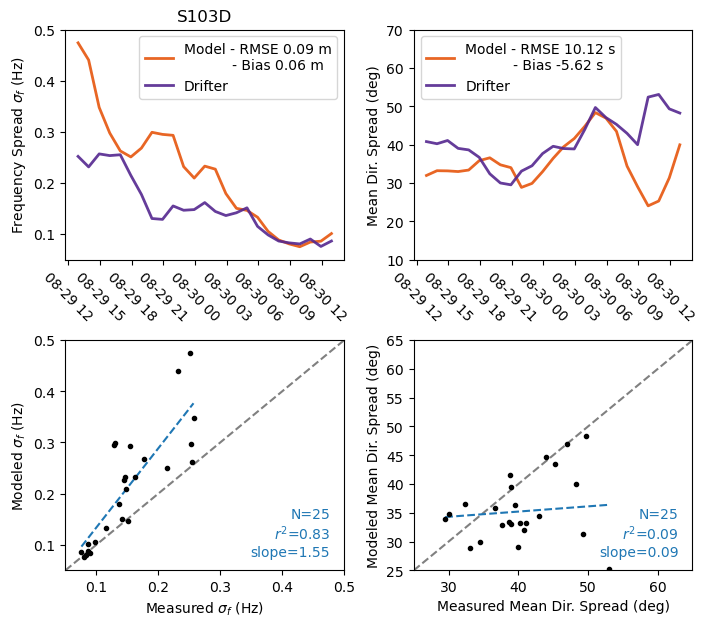

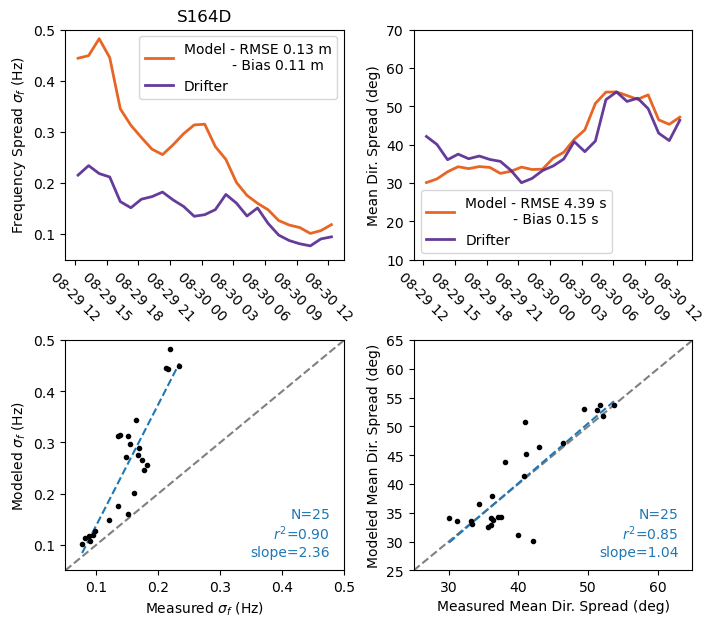

In [9]:

for item in ulist:

    id_list = np.squeeze( np.argwhere(np.array(did[:])==item) )

    fig, axs = plt.subplots(2,2, figsize=(7,6))
    fig.tight_layout()
    #fig.constrained_layout=True
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.2   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.35)

    rmse = np.sqrt( np.mean( (np.array(sigfs)[id_list] - np.array(sigf)[id_list])**2) )
    bias = np.mean( np.array(sigfs)[id_list] - np.array(sigf)[id_list] )
    ts = 'Model - RMSE {:.2f} m\n           - Bias {:.2f} m'.format(rmse, bias)
    sigf_bias_list.append( bias )
    sigf_rmse_list.append( rmse )
    axs[0,0].plot(np.array(dt)[id_list], np.array(sigfs)[id_list],'-',linewidth=2,c=oranges[3], alpha=.9, label=ts) 
    axs[0,0].plot(np.array(dt)[id_list], np.array(sigf)[id_list],'-',linewidth=2,c=purples[4],alpha=.9, label='Drifter')
    axs[0,0].set_ylim((0.05,.5))
    axs[0,0].set_ylabel(r'Frequency Spread $\sigma_f$ (Hz)')
    axs[0,0].legend()
    axs[0,0].tick_params(axis='x', rotation=-45)
    axs[0,0].set_title(item)

    rmse = np.sqrt( np.mean( (np.array(mdirsobs)[id_list] - np.array(mdirsmod)[id_list])**2) )
    bias = np.mean( np.array(mdirsmod)[id_list] - np.array(mdirsobs)[id_list] )
    ts = 'Model - RMSE {:.2f} s\n           - Bias {:.2f} s'.format(rmse, bias)
    mdirs_bias_list.append( bias )
    mdirs_rmse_list.append( rmse )
    axs[0,1].plot(np.array(dt)[id_list], np.array(mdirsmod)[id_list],'-',linewidth=2,c=oranges[3], alpha=.9, label=ts) 
    axs[0,1].plot(np.array(dt)[id_list], np.array(mdirsobs)[id_list],'-',linewidth=2,c=purples[4],alpha=.9, label='Drifter')
    axs[0,1].set_ylim((10,70))
    axs[0,1].set_ylabel(r'Mean Dir. Spread (deg)')
    axs[0,1].legend()
    axs[0,1].tick_params(axis='x', rotation=-45)
    
    # directional spread v. frequency spread is not very informative
    # axs[1,0].plot( np.array(mdirsmod)[id_list], np.array(sigfs)[id_list],'.',linewidth=2,c=oranges[3], alpha=1)
    # axs[1,0].set_xlim((10,70))
    # axs[1,0].set_xlabel(r'Mean Dir. Spread (deg)')
    # axs[1,0].set_ylabel(r'Frequency Spread $\sigma_f$ (Hz)')

    gradient, intercept, r_value, p_value, std_err = stats.linregress(np.array(sigf)[id_list],np.array(sigfs)[id_list])
    mn=np.min(np.array(sigf)[id_list])
    mx=np.max(np.array(sigf)[id_list])
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(np.array(sigf)[id_list]),r_value,gradient)
    axs[1,0].plot([.05,.5],[.05,.5],'--',c='gray')
    axs[1,0].plot(x1d,y1d,'--',c='tab:blue')
    axs[1,0].plot(np.array(sigf)[id_list],np.array(sigfs)[id_list],'.k')
    axs[1,0].text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=axs[1,0].transAxes,\
                 horizontalalignment='right', verticalalignment='bottom')
    axs[1,0].set_ylabel('Modeled $\sigma_f$ (Hz)')
    axs[1,0].set_xlabel('Measured $\sigma_f$ (Hz)')
    axs[1,0].axis([.05,.5, 0.05 ,.5])
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(np.array(mdirsobs)[id_list],np.array(mdirsmod)[id_list])
    mn=np.min(np.array(mdirsobs)[id_list])
    mx=np.max(np.array(mdirsobs)[id_list])
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(np.array(mdirsobs)[id_list]),r_value,gradient)
    axs[1,1].plot([25,65],[25,65],'--',c='gray')
    axs[1,1].plot(x1d,y1d,'--',c='tab:blue')
    axs[1,1].plot(np.array(mdirsobs)[id_list],np.array(mdirsmod)[id_list],'.k')
    axs[1,1].text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=axs[1,1].transAxes,\
                 horizontalalignment='right', verticalalignment='bottom')
    axs[1,1].set_ylabel('Modeled Mean Dir. Spread (deg)')
    axs[1,1].set_xlabel('Measured Mean Dir. Spread (deg)')
    axs[1,1].axis([25, 65, 25, 65])
    
    dirname = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
    figname = 'spreading_panel_'+item+'.png'
    plt.savefig(dirname+figname, dpi=200, bbox_inches='tight' )

#### simple map with all drifters

In [10]:
hurpth

array([[-86.1,  21.3],
       [-86.3,  21.2],
       [-86.8,  20.5],
       [-86.3,  19.8],
       [-85.7,  20. ],
       [-85.4,  19.8],
       [-85.2,  19.8],
       [-85.2,  20.6],
       [-85.2,  21.2],
       [-85.1,  21.8],
       [-85. ,  22.6],
       [-84.8,  23.8],
       [-84.8,  25.3],
       [-84.7,  26.9],
       [-84.5,  28.3],
       [-83.6,  30. ],
       [-82.5,  31.5],
       [-80.9,  32.7],
       [-78.8,  33.6],
       [-77. ,  33.7],
       [-74.4,  33.6],
       [-72.3,  33.4],
       [-70.5,  32.8],
       [-68.8,  32.3],
       [-67. ,  32.1],
       [-65.6,  31.9],
       [-64.7,  31.7],
       [-63.9,  31.7],
       [-63.2,  31.9]])

/vortexfs1/home/csherwood/mambaforge/envs/NOPP/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/vortexfs1/home/csherwood/mambaforge/envs/NOPP/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


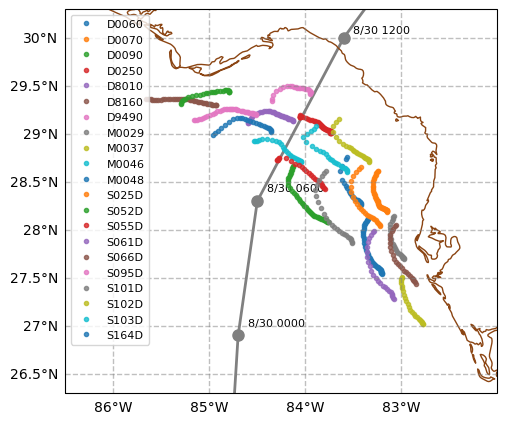

In [11]:
cpc = crs.PlateCarree()

fig1 = plt.figure()
ax1 = fig1.add_axes((0.12, 0.125, 0.8, 0.8),projection=cpc)
ax1.set_extent([-86.5, -82, 26.3, 30.3])
ax1.add_feature(cf.STATES, edgecolor='saddlebrown', linewidth=1, zorder=1)
gl = ax1.gridlines(crs=cpc, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.ylabels_right = False
gl.xlabels_top = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

offx = .1
offy = .1
ax1.text(-84.7+offx,  26.9+offy, '8/30 0000', zorder=1, fontsize=8)
ax1.text(-84.5+offx,  28.3+offy, '8/30 0600', zorder=1, fontsize=8)
ax1.text(-83.6+offx,  30+offy/2, '8/30 1200', zorder=1, fontsize=8)

ax1.plot(hurpth[:,0],hurpth[:,1],'o-', markersize=8, linewidth=2, c='gray', zorder=0)
for item in ulist:
    id_list = np.squeeze( np.argwhere(np.array(did[:])==item) )
    ax1.plot(np.array(lon)[id_list], np.array(lat)[id_list], '.', zorder=2, label=item, alpha=.8)
plt.legend(fontsize=8)
dirname = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
figname = 'map_idalia_all_drifters.png'
plt.savefig(dirname+figname, dpi=200, bbox_inches='tight' )

/tmp/ipykernel_162159/2945423942.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure()


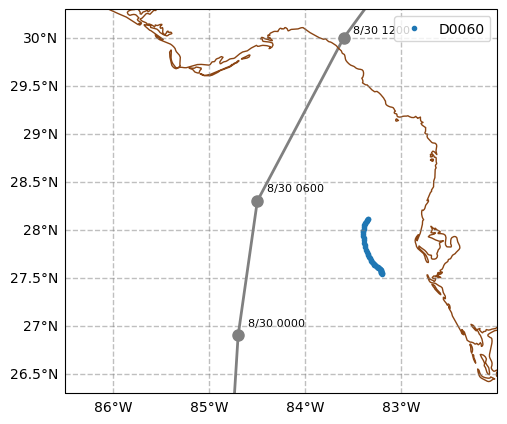

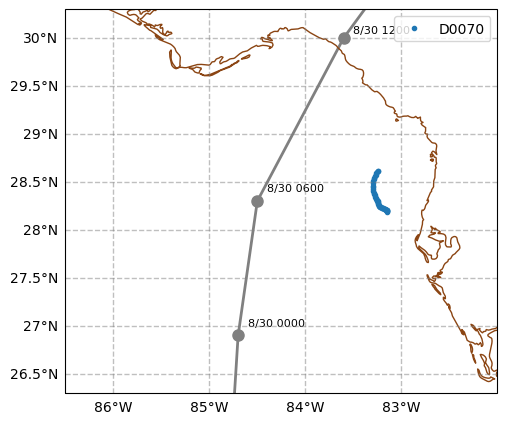

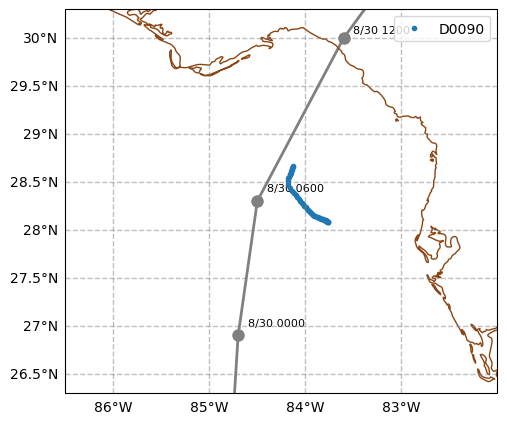

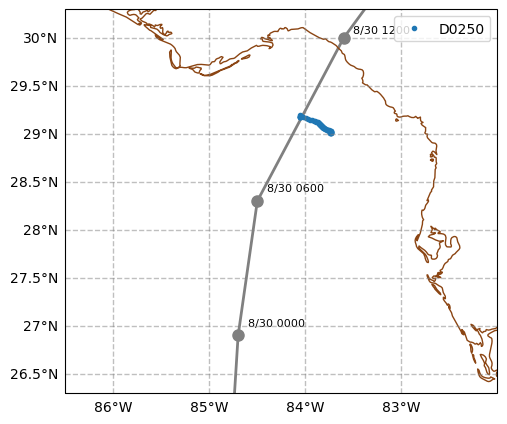

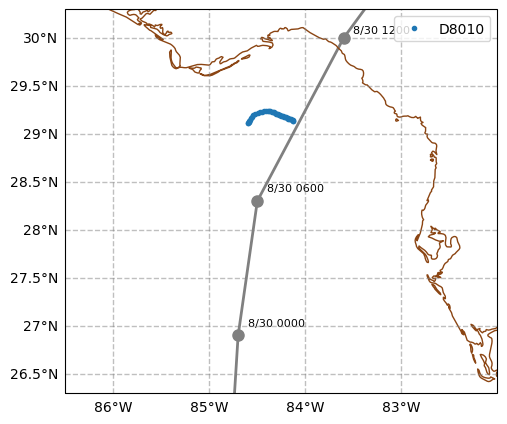

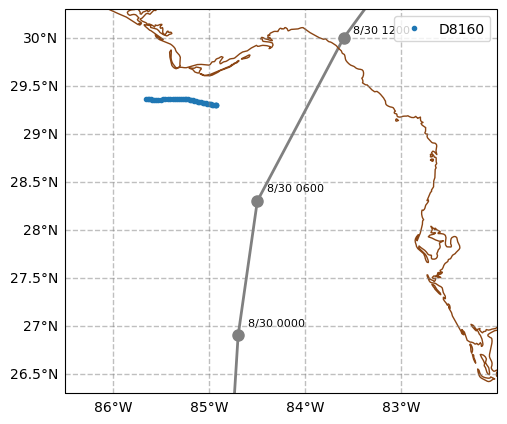

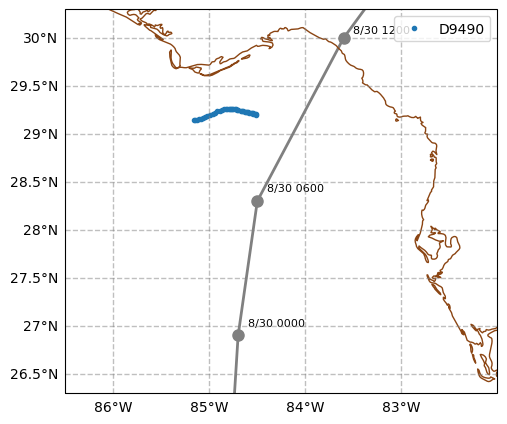

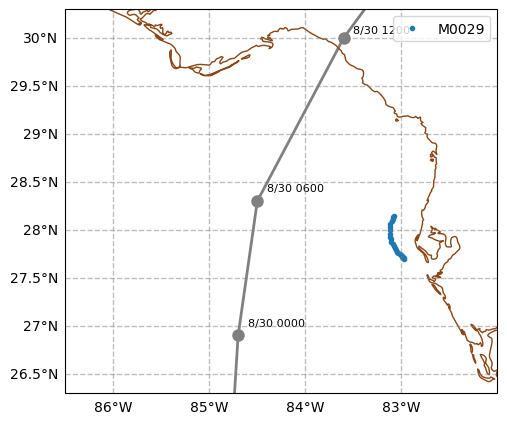

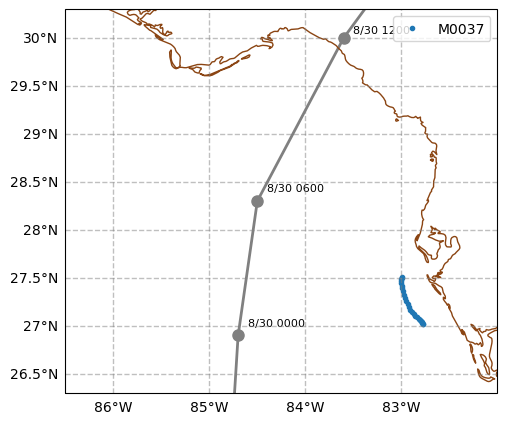

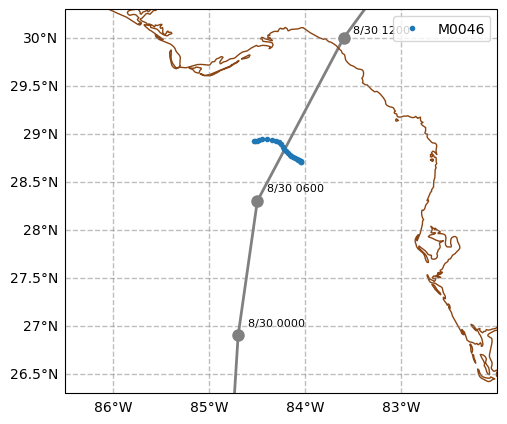

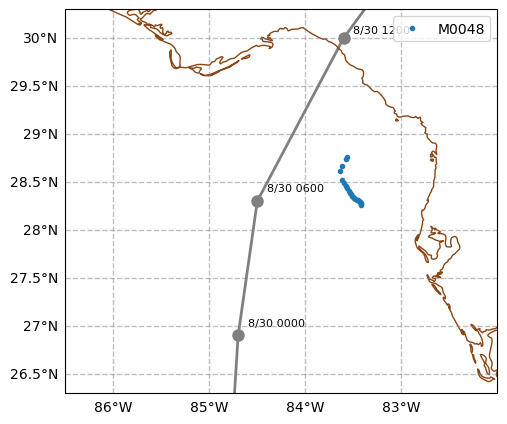

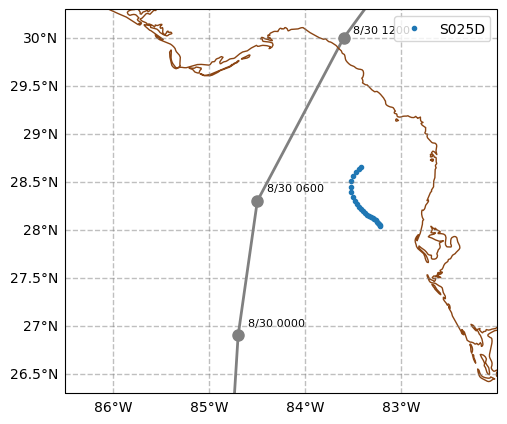

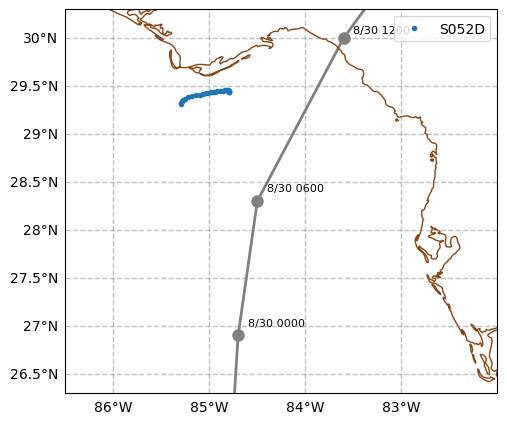

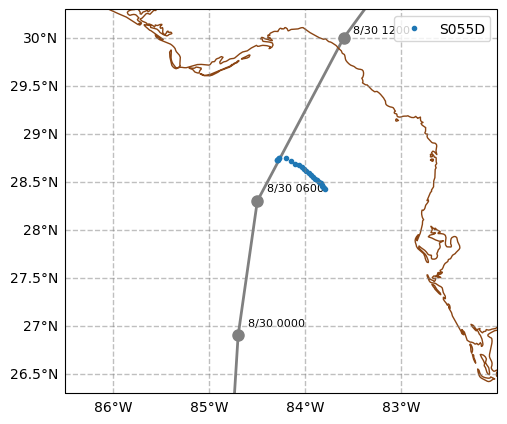

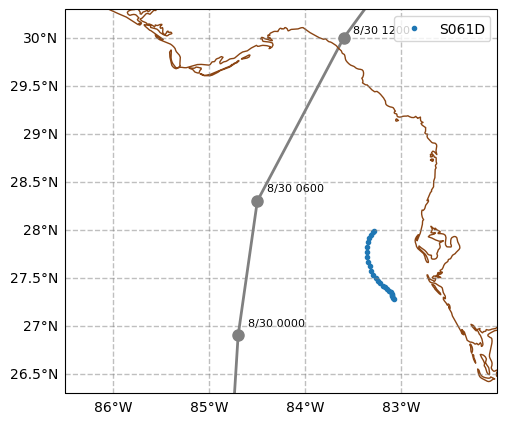

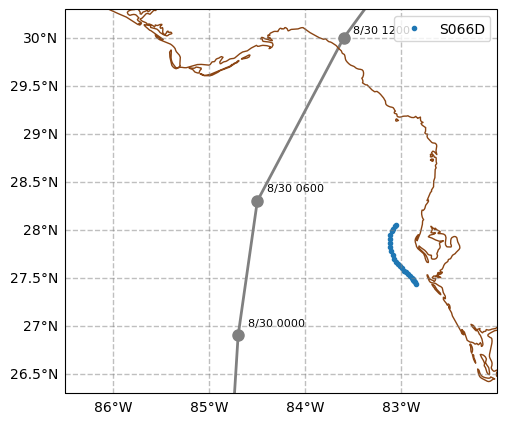

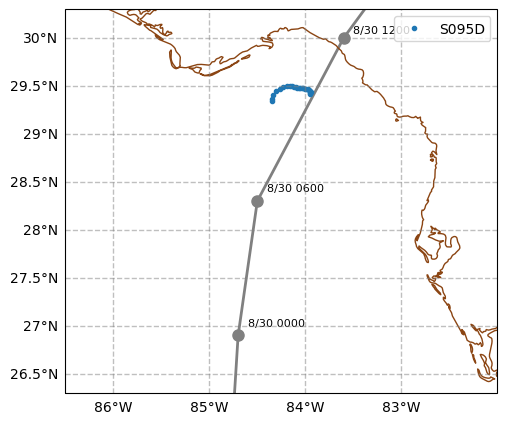

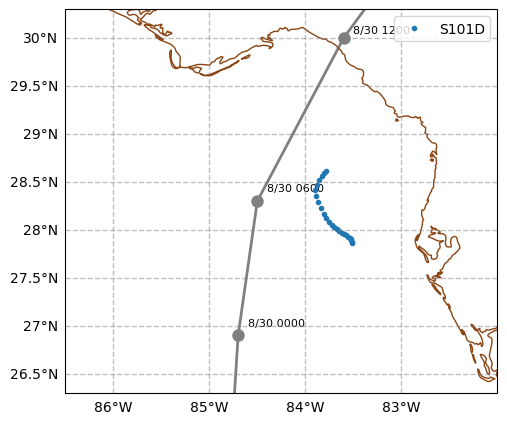

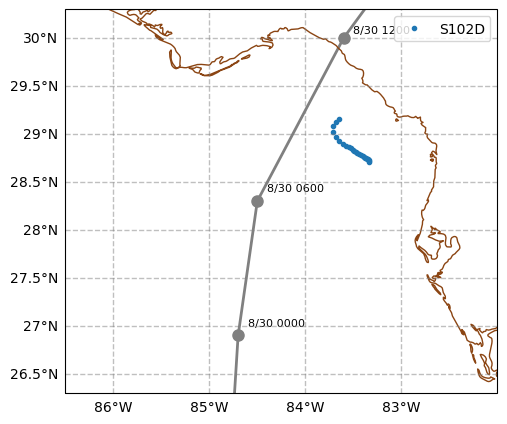

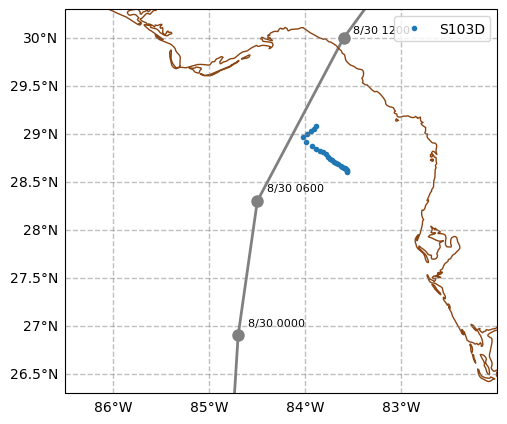

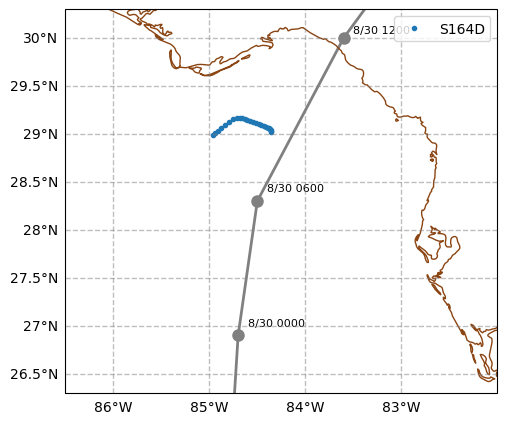

In [12]:
cpc = crs.PlateCarree()
for item in ulist:
    id_list = np.squeeze( np.argwhere(np.array(did[:])==item) )
    fig1 = plt.figure()
    ax1 = fig1.add_axes((0.12, 0.125, 0.8, 0.8),projection=cpc)
    ax1.set_extent([-86.5, -82, 26.3, 30.3])
    ax1.add_feature(cf.STATES, edgecolor='saddlebrown', linewidth=1, zorder=1)
    gl = ax1.gridlines(crs=cpc, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xlabels_top = False
    # gl.xformatter = LONGITUDE_FORMATTER
    # gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    offx = .1
    offy = .1
    ax1.text(-84.7+offx,  26.9+offy, '8/30 0000', zorder=1, fontsize=8)
    ax1.text(-84.5+offx,  28.3+offy, '8/30 0600', zorder=1, fontsize=8)
    ax1.text(-83.6+offx,  30+offy/2, '8/30 1200', zorder=1, fontsize=8)

    ax1.plot(hurpth[:,0],hurpth[:,1],'o-', markersize=8, linewidth=2, c='gray', zorder=0)
    
    ax1.plot(np.array(lon)[id_list], np.array(lat)[id_list], '.', zorder=2, label=item)
    plt.legend()
    dirname = '/vortexfs1/home/csherwood/proj/NOPP_Idalia/'
    figname = 'map_idalia_drifter_'+item+'.png'
    plt.savefig(dirname+figname, dpi=200, bbox_inches='tight' )

In [13]:
print( 'Mean Hm0 RMSE: {:.02f}'.format( np.mean(np.array(hm0_rmse_list))))
print( 'Mean Hm0 bias: {:.02f}'.format( np.mean(np.array(hm0_bias_list))))
print( 'Mean Tp RMSE: {:.02f}'.format( np.mean(np.array(tp_rmse_list))))
print( 'Mean Tp bias: {:.02f}'.format( np.mean(np.array(tp_bias_list))))
print( 'Mean mdir RMSE: {:.02f}'.format( np.mean(np.array(mdir_rmse_list))))
print( 'Mean mdir bias: {:.02f}'.format( np.mean(np.array(mdir_bias_list))))
print( 'Mean mdirs RMSE: {:.02f}'.format( np.mean(np.array(mdirs_rmse_list))))
print( 'Mean mdirs bias: {:.02f}'.format( np.mean(np.array(mdirs_bias_list))))

Mean Hm0 RMSE: 0.93
Mean Hm0 bias: 0.18
Mean Tp RMSE: 2.48
Mean Tp bias: 0.09
Mean mdir RMSE: 0.00
Mean mdir bias: 8.98
Mean mdirs RMSE: 8.34
Mean mdirs bias: -4.15


In [14]:
# loop through unigue ids
for uid in ulist:
    # find entries for that uid
    in_id = []
    for ia, id in enumerate( did ):
        if id==uid:
            in_id.append(ia)
    
    print(in_id)
    print(np.array(lat)[in_id])

[251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
[27.5413887 27.5457707 27.550583  27.5548243 27.5586952 27.562536
 27.5660501 27.5693931 27.5731599 27.5784241 27.5836212 27.5886117
 27.5930171 27.5976796 27.6035901 27.6095765 27.615898  27.623085
 27.6306317 27.6389123 27.6484972 27.6581024 27.6682747 27.6792435
 27.6911204 27.7037341 27.7187421 27.7341495 27.7512611 27.7691444
 27.7869697 27.8261279 27.8466226 27.8669575 27.88928   27.9103651
 27.9325017 27.9533663 27.9730511 27.9923105 28.012021  28.0302617
 28.0461234 28.0616298 28.0742425 28.0842286 28.0939898 28.1018217
 28.108841  28.1138097]
[301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 